## Getting finite-difference derivative of the energy with respect to induced dipole:

Hi Asmus,

  I have been discussing with Elvar about the implementation of SCME in the QM/MM and this has led to a two a
separation of the issues into two categories:

1.  Given the current implementation of polarizability in SCME where an SCF calculation is carried out by generating a
field from current values of multipole moments, then calculating how much the multipole moments should be changed
given the molecular polarizabilities, then recalculating the fields, etc., there are correction terms that need to be added
at the interface and they may fix the energetics.  Elvar is working on implementing those terms now and apparently this
will be ready in just a couple of days.

2.  However, a much deeper issue had been bothering Elvar, namely whether the procedure described in 1. really does
correspond to a minimization of the energy with respect to the multipole moments.  He has a paper by the Amoeba
gang that approaches this in a different way, finds the multipole moments in such a way as to set the derivative of the
total energy with respect to multipole moments to zero. This would represent a dramatic departure from the usual
procedure.

I think I have managed to convince Elvar to put concern 2 aside for the moment and complete, at least as a first step,
the extra terms needed to complete 1.  But, we were thinking that it would be interesting to test whether procedure 1 and procedure 2 give the same result.  Would you be willing to test that using, say a H2O dimer, and then perhaps also a trimer?  What you would do is to apply process 1 until convergence is reached.  Then, calculate numerically with finite differences the derivative of the energy with respect to the induced dipole (let’s leave out the induced quadruple, it should be enough to test this for the dipole).  The question is whether the derivative is zero or not.  If it is zero, then process 1 is fine. If it is not zero, the process 1 is not good enough and we need to implement process 2.  


The polarizability is of course the parameter that connects the energy and the field, the polarizability says how much the molecular moment will change in order to minimize the energy of the molecule in a field.  The polarizability of a collection of molecules will necessarily be approximated by the polarizability of individual molecules, to take into account the change in polarizability due to chemical interaction between the molecules requires ab initio and that is not what we are going to do in any case. But, somehow the Amoeba approach is hinting that due to some non-linear interference the response of the collection of molecules to the field cannot be represented by the molecular polarizabilities, one needs to minimize the energy of the collection of molecules with respect to the multipole moments.


First you would do a calculation for a H2O dimer and get convergence.  Store the molecular dipole moments. Then,
add a small x, y or z component to the dipole moment and evaluate the energy again.  So, you displace the dipole moment vector a bit, analogous to the way you displace the atomic position vector when calculating atomic force.


So i need to:
1. Evaluate energy using total, self consistent loop
2. Do displacements like calculate_numerical_energy() (steal that from ASE and replace position with dipole.. and then maybe later make the same for qpole)
3. Evaluate the energy again for each displacement **without restarting the induction loop**

$$
E_\mathrm{es+ind} = - \frac{1}{2} \sum_i
\left(
\mu_\alpha^i \tilde{F^i}_\alpha + 
\frac{1}{3} \Theta^i_{\alpha \beta} \tilde{F^i}_{\alpha \beta} +
\frac{1}{15} \Omega^i_{\alpha \beta \gamma} \tilde{F^i}_{\alpha \beta \gamma} +
\frac{1}{105} \Phi^i_{\alpha \beta \gamma \delta} \tilde{F^i}_{\alpha \beta \gamma \delta} +
\right)
$$

So for a single dipole

### How to avoid SCME messing up the perturbed poles
- readPoles reads in poles as d0, q0, ... from the input file
- rotatePoles make dpole0, ... out of d0
- dpole is set in beginning of gaga.f via setUnpolPoles (in molecProperties.f)  
- ASE gets out dpole, which means it is **already rotated** and passing in something like that would then also be.

- In the end, the thing which I have most control over is just to rewrite calcEdip_quad in python. 


### Re-evaluating the energy in a dimer
1. Pertub pole 1
2. re-evaluate field and derivs at pole 2
3. calculate energy


In [6]:
%reset -f

%load_ext autoreload
%autoreload 2

import numpy as np
from ase.data import s22
from ase.calculators.scme.new_scme_interface import SCME_Interface
dimer = s22.create_s22_system('Water_dimer')

center = dimer[0].position
h = dimer[3].position[1]-dimer[0].position[1]
l = np.linalg.norm(dimer[0].position - dimer[3].position)
angle = np.arcsin(h/l)
dimer.rotate(angle, '-z', center=center)


dimer.center(vacuum=50.)
dimer.calc = SCME_Interface(dimer)
e = dimer.get_potential_energy()

print(e)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
-0.222592887141


### convert calcEdip_quad to python
These are the values of the inputs i'm not too sure about:
NC:           0  
a:   103.61311226459743        101.14114653686572        101.51712200000000  
a2:  51.806556132298716        50.570573268432859        50.758561000000000  
rMax2: 121.00000000000000 <-- hardcoded into gaga.f as 11^2  
iSlab: F  



a = size of simulation cell (x,y,z)  
a2 = a / 2.. yes really.


In [109]:
def tang_toenniesN(r, n):
    b = 4.4
    x = b * r
    f = 1
    t = np.exp(-x)
    for k in range(n + 1):
        f = f - t
        t = t * x / (k + 1)
    f = np.sqrt(f)
    return f

def tang_toenniesNdF(r, n):
    b = 4.4
    x = b * r
    f = 1.0
    df = 0.0
    t = np.exp(-x)
    for k in range(n + 1):
        f = f - t
        df = df - t * b * (-1.0 + k / x)
        t = t * x / (k + 1)

    f = np.sqrt(f)
    df = df / (2.0 * f)

    return f, df




def SF(r):
    rL1 = 0.
    rH1 = 5. 
    rL2 = 9.
    rH2 = 11.
    
    if (r >= rH2) | (r <= rL1):
        swFunc = 0.0
    elif (r >= rH1) & (r <= rL2):
        swFunc = 1.0
    elif (r < rH1):
        swFunc = tang_toenniesN(r, 6)
    else:
        x = (r - rL2)/(rH2 - rL2)
        x2 = x**2
        x3 = x2 * x
        swFunc = 1.0 + x3 * (-6.0 * x2 + 15.0 * x - 10.0)

    return swFunc

def SFdsf(r):
    rL1 = 0.
    rH1 = 5. 
    rL2 = 9.
    rH2 = 11.
    if (r >= rH2) | (r <= rL1):
        swFunc = 0.0
        dSdr = 0.0
    elif (r >= rH1) & (r <= rL2):
        swFunc = 1.0
        dSdr = 0
    elif  (r < rH1):
        swFunc, dSdr = tang_toenniesNdF(r, 6)
    else:
        x = (r - rL2)/(rH2 - rL2)
        dr = 1.0 / (rH2 - rL2)
        x2 = x * x
        x3 = x2 * x
        swFunc = 1.0 + x3 * (-6.0 * x2 + 15.0 * x - 10.0)
        dSdr = 30.0 * x2 * (- x2 + 2.0 * x - 1.0) * dr

    return sWfunc, dSdr
    

def dField(dr, r2, r3, r5, dpole, m):
    eD = np.zeros(3)
    dEdr = np.zeros((3, 3))
    mDr = dpole[0, m] * dr[0] + dpole[1, m] * dr[1] + dpole[2, m] * dr[2]
    print mDr
    for i in range(3):
        eD[i] = (3.0 * mDr * dr[i] / r2 - dpole[i ,m]) / r3
        for j in range(i, 3):
            dEdr[i ,j] = (dpole[i, m] * dr[j] + dpole[j, m] * dr[i] - 5. *
                          mDr * dr[i] * dr[j] / r2) * 3.0 / r5
            if i == j:
                dEdr[i, j] = dEdr[i, j] + mDr * 3.0 / r5

    u = mDr / r3
    return u, eD, dEdr

def qField(dr, r2, r5, r7, qpole, m):
    eq = np.zeros(3)
    dEdr = np.zeros((3, 3))
    v = np.zeros(3)
    rQr = 0.0
    for j in range(3):
        for i in range(3):
            v[i] = v[i] + qpole[i, j, m] * dr[j]
            rQr += dr[i] * qpole[i, j, m] * dr[j]
    for i in range(3):
        eq[i] = 2. * (2.5 * rQr / r2 * dr[i] - v[i]) / r5
        for j in range(i, 3):
            dEdr[i, j] = (-2 * qpole[i, j, m] * r2 + 10 * (v[j] *
                         dr[i] + v[i] * dr[j]) - 35 * rQr * dr[i] * dr[j] / r2) / r7
            if i == j:
                dEdr[i, j] = dEdr[i, j] + 5.00 * rQr / r7

    u = rQr / r5

    return u, eq, dEdr


def calcEdip_quad(atoms, dpole, qpole):
    """ Field from Dipole and quadropole. """
    # outputs: uD, uQ, eT, dEdr, 
    uD = 0.
    uQ = 0.
    dr = np.zeros(3)
    rMax2 = np.Inf  # for the moment. It's hardcoded in the fortran code.. weird
    nM = len(atoms) // 3
    a = atoms.cell.diagonal()
    a2 = a/2.
    molit = lambda L,N:[L[i*N:(i+1)*N] for i in range(len(L)//N)]
    rCM = np.array([mol.get_center_of_mass() for mol in molit(atoms, 3)]).T  # because fortran style 
    
    eT = np.zeros((3, nM))
    dEdr = np.zeros((3, 3, nM))

    for i in range(nM):
        for j in range(3):
            eT[j, i] = 0.
            for k in range(3):
                dEdr[k, j, i] = 0.0
        for j in range(nM):
            if j == i: # goto 11
                continue 
            for k in range(3):
                dr[k] = rCM[k, i] - rCM[k, j]
                if dr[k] > a2[k]:  # a MIC
                    dr[k] = dr[k] - a[k]
                elif dr[k] < -a2[k]:
                    dr[k] = dr[k] + a[k]

            r2 = dr[0]**2 + dr[1]**2 + dr[2]**2

            if r2 > rMax2:
                continue  # out of cutoff
            r1 = np.sqrt(r2)
            swFunc = SF(r1)  

            r3 = r1 * r2
            r5 = r3 * r2
            r7 = r5 * r2

            # Dipole Field
            u, eD, dEdr1 = dField(dr, r2, r3, r5, dpole, j) 
            uD += u # but u is just zero!! argh - not in my implementation.. but..
            for k in range(3):
                eT[k, i] += eD[k] * swFunc
                for l in range(3):
                    dEdr[k, l, i] += dEdr1[k, l] * swFunc

            # Quadrupole Field
            u, eq, dEdr1 = qField(dr, r2, r5, r7, qpole, j)
            uQ += u
            for k in range(3):
                eT[k, i] += eq[k] * swFunc
                for l in range(3):
                    dEdr[k, l, i] += dEdr1[k, l] * swFunc 
    print uD, uQ
    return eT, dEdr

#----------------------------------------------------------------------+
#     Calculate derivatives of the electric field.                     |
#----------------------------------------------------------------------+
def calcDv(atoms, dpole, qpole, opole, hpole):
           #d1v, d2v, d3v, d4v, d5v, rMax2, fsf)

    d1v = np.zeros((3, nM))
    d2v = np.zeros((3, 3, nM))
    d3v = np.zeros((3, 3, 3, nM))
    d4v = np.zeros((3, 3, 3, 3, nM))
    d5v = np.zeros((3, 3, 3, 3, 3, nM))
    
    d1d = np.zeros(3)
    d2d = np.zeros((3, 3))
    d3d = np.zeros((3, 3, 3))
    d4d = np.zeros((3, 3, 3, 3))
    d5d = np.zeros((3, 3, 3, 3, 3))

    d1a = np.zeros_like(d1d)
    d2a = np.zeros_like(d2d)
    d3a = np.zeros_like(d3d)
    d4a = np.zeros_like(d4d)
    d5a = np.zeros_like(d5d)
    
    rMax2 = np.Inf  # for the moment. It's hardcoded in the fortran code.. weird
    nM = len(atoms) // 3
    a = atoms.cell.diagonal()
    a2 = a/2.
    molit = lambda L,N:[L[i*N:(i+1)*N] for i in range(len(L)//N)]
    rCM = np.array([mol.get_center_of_mass() for mol in molit(atoms, 3)]).T  # because fortran style 
    
    d = np.zeros(3)
    
    for n in range(nM):
        for m in range(nM):
            if n == m:
                continue
            for i in range(3):
                dr[i] = rCM[i, n] - rCM[i, m]
                if dr[i] > a2[i]:
                    dr[i] = dr[i] - a[i]
                elif dr[i] < -a2[i]:
                    dr[i] = dr[i] + a[i]
                    
                #dr[i] = dr[i] + re[i]

            r2 = dr[0]**2 + dr[1]**2 + dr[2]**2 
            if r2 > rMax2:
                continue
            r1 = np.sqrt(r2)
            swFunc, dSdr = SFdsf(r1, swFunc, dSdr)
                     

            for i in range(3):
                d[i] = dpole[i, m]
                     
            d1a, d2a, d3a, d4a, d5a = dDpole(d, dr)

            for j in range(3):
                for i in range(3):
                    q[i, j] = qpole[i, j, m]
            d1d, d2d, d3d, d4d, d5d = dQpole(q, dr)
            addDerivA(d1a, d2a, d3a, d4a, d5a, d1d, d2d, d3d, d4d, d5d)

            for k in range(3):
                for j in range(3):
                    for i in range(3)
                        o[i, j, k] = opole[i, j, k, m]
            d1d, d2d, d3d, d4d, d5d = dOpole(o, dr)
            addDerivA(d1a, d2a, d3a, d4a, d5a, d1d, d2d,d3d, d4d, d5d)
            
            for l in range(3):
                for k in range(3):
                    for j in range(3):
                        for i in range(3)
                            h[i, j, k, l] = hpole[i, j, k, l, m]
            d1d, d2d, d3d, d4d, d5d = dHpole(h, dr)
            addDerivA(d1a, d2a, d3a, d4a, d5a, d1d, d2d, d3d, d4d, d5d)
            addDeriv(d1v, d2v, d3v, d4v, d5v, d1a, d2a, d3a, d4a, d5a, n, swFunc)
            
            fsf = addSwitchingForce(d1a, d2a, d3a, d4a, n,dSdr, dr, r1, dpole, qpole, opole, hpole)

    #Copy all the permutations. (Is this really necessary??)
    for i in range(3):
        for j in range(3):
            in2[0] = i
            in2[1] = j
            insertIN(in2, 1)
            
            for n in range(nM):
                d2v[i, j, n] = d2v[in2[0], in2[1], n]
            
            for k in range(3):
                for ii in range(2):
                    in3[ii] = in2[ii]
                                   
                in3[2] = k
                insertIN(in3, 2)

                for n in range(nM):
                    d3v[i, j, k, n] = d3v[in3[0], in3[1], in3[2], n]

                for l in range(3):
                    for ii in range(3):
                         in4[ii] = in3[ii]
                    in4[3] = 0  
                    insertIN(in4, 3)

                    for n in range(nM):
                        d4v[i, j, k, l, n] = d4v[in4[0], in4[1], in4[2], in4[3], n]
                     
                    for m in range(3):
                        for ii in range(4):
                            in5[ii] = in4[ii]
                        in5(5) = m
                        insertIN(in5, 4)
                     
                        for n in range(nM):
                            d5v[i, j, k, l, m, n] = d5v[in5[0], in5[1], in5[2], in5[3],in5[4], n]
                                   
      return d1v, d2v, d3v, d4v, d5v


SyntaxError: invalid syntax (<ipython-input-109-2ff761331fcd>, line 223)

In [107]:
from ase import units as unit

dc = -1 * unit.Debye / unit.Bohr
qc = -1 * unit.Debye / unit.Bohr**2

print dimer.calc.dpoles.T/dc  # This is the same as in SCME, so put it into calcEdip_quad like this
eT, dEdr = calcEdip_quad(dimer, dimer.calc.dpoles.T/dc, dimer.calc.qpoles.T/qc)

[[ 1.20443849  1.40799641]
 [ 1.67292183 -1.62465859]
 [ 0.          0.        ]]
-3.91421240551
3.68518783628
-0.00930377084008 0.00421964325251


In [98]:
print eT
print '************************************************************************************'
print dEdr

[[  1.91669927e-01   1.92317770e-01]
 [  4.40825153e-02  -2.63303414e-02]
 [  9.31364776e-16   9.12924513e-16]]
************************************************************************************
[[[  2.26082066e-01  -2.29355503e-01]
  [  3.97804988e-02   1.13583995e-02]
  [  1.46254035e-15  -1.44157885e-15]]

 [[  0.00000000e+00   0.00000000e+00]
  [ -9.50041261e-02   1.00842509e-01]
  [  9.71726184e-17  -2.28428192e-17]]

 [[  0.00000000e+00   0.00000000e+00]
  [  0.00000000e+00   0.00000000e+00]
  [ -1.31077939e-01   1.28482703e-01]]]


[[ 1.20443849  1.40799641]
 [ 1.67292183 -1.62465859]
 [ 0.          0.        ]]


In [1]:
%reset -f

%load_ext autoreload
%autoreload 2

In [2]:
from ase import units as unit
from scme import calcEdip_quad, calcDv, calcEnergy
import numpy as np
from ase.data import s22
from ase.calculators.scme.new_scme_interface import SCME_Interface
dimer = s22.create_s22_system('Water_dimer')

center = dimer[0].position
h = dimer[3].position[1]-dimer[0].position[1]
l = np.linalg.norm(dimer[0].position - dimer[3].position)
angle = np.arcsin(h/l)
dimer.rotate(angle, '-z', center=center)


dimer.center(vacuum=50.)
dimer.calc = SCME_Interface(dimer)
e = dimer.get_potential_energy()

dc = -1 * unit.Debye / unit.Bohr
qc = -1 * unit.Debye / unit.Bohr**2
oc = -1 * unit.Debye / unit.Bohr**3
hc = -1 * unit.Debye / unit.Bohr**4

d = dimer.calc.dpoles.T / dc
q = dimer.calc.qpoles.T / qc
o = dimer.calc.opoles.T / oc
h = dimer.calc.hpoles.T / hc

d0 = dimer.calc.dpoles0.T / dc
q0 = dimer.calc.qpoles0.T / qc

#eT, dEdr = calcEdip_quad(dimer, d, q)

d1v, d2v, d3v, d4v, d5v = calcDv(dimer, d, q, o, h)

utot = calcEnergy(d0, q0, o, h, d1v, d2v, d3v, d4v, 2)
utot *= 14.39975841 / 4.803206799**2  ## 4.8 is Debye
utot_fortran =  -0.2984947

print '***********************'
print utot, utot_fortran
print utot - utot_fortran

***********************
-0.298494995612 -0.2984947
-2.95611907786e-07


In the fotran code, nothing happens to dXv after calcDv, before they are used in calcEnergy. 

In python calcDv, dXpole have been tested (somewhat). The error must be in calcDv.

**rCM is different between python and fortran! Currently hardcoded into python** 

In [36]:
# checks
d_fortran = np.array([1.4079964140597296, -1.6246585869558519, 0.])
d_python = np.array([1.40799641, -1.62465859,  0.])
print '************* d into dDpole *************'
print d_fortran - d_python


q_fortran = np.array([-1.9855430115453376, -1.1487176712740244, 0.0000000000000000, -1.1487176712740244, -0.82173599883118775, 0.0000000000000000, 0.0000000000000000, 0.0000000000000000, 2.8072789370563322])
q_fortran = q_fortran.reshape((3, 3), order='F')
q_python = np.array([[-1.98554301, -1.14871767,  0.        ],
                     [-1.14871767, -0.821736,    0.        ],
                     [ 0.,          0.,          2.80727894]])

print '************* q into dQpole *************'
print q_fortran - q_python

###############################################################
d2q_python = np.array([[-0.12230565,  0.03600084,  0.        ],
                       [ 0.        ,  0.04563473,  0.        ],
                       [ 0.        ,  0.,          0.07667091]])

d2q = np.zeros((3, 3))
d2q[0, 0] = -0.12230564757929813
d2q[0, 1] =   3.6000838854176043E-002
d2q[0, 2] =   0.0000000000000000
d2q[1, 1] =   4.5634734754679510E-002
d2q[1, 2] =   0.0000000000000000
d2q[2, 2] =   7.6670912120651774E-002
print '************* d2q inside dQpole *************'
print d2q - d2q_python
###############################################################

d2d_fortran = np.array([-0.12230564757929813,        6.9532165391720354E-310,   6.9532165391704544E-310,   3.6000838854176043E-002,   4.5634734754679510E-002,   6.9532282916866993E-310,   0.0000000000000000,        0.0000000000000000,        7.6670912120651774E-002])
d2d_fortran = d2d_fortran.reshape((3, 3), order='F')

d2d_python = np.array([[-0.12230565,  0.03600084,  0.        ],
                       [ 0.        ,  0.04563473,  0.        ],
                       [ 0.        ,  0.,          0.07667091]])

print '************* d2d JUST after dQpole, just before add: *************'
print d2d_fortran - d2d_python

###############################################################

d1a_fortran_after_first_add = np.array([-0.19519533791902705, 2.6640798150103139E-002, 0.0])
d1a_python_after_first_add = np.array([-0.19519534,  0.0266408,   0.        ])
print '************* d1a after addDerivA *************'
print d1a_fortran_after_first_add - d1a_python_after_first_add
###############################################################

d2a_fortran_after_first_add = np.array([ -0.22941810091587009,        6.9388441859319595E-310,   6.9532117373519760E-310,  -4.0490993031108632E-002 ,  9.6394435977828541E-002 ,  6.3797168643149702E-314 ,  0.0000000000000000   ,     0.0000000000000000   ,    0.13302366423407466])
d2a_fortran_after_first_add = d2a_fortran_after_first_add.reshape((3, 3), order='F')
d2a_fortran_after_first_add = np.array([-0.22941810091587009 ,        6.9323957092276102E-310,   6.9532159085877513E-310,  -4.0490993031108632E-002,   9.6394435977828541E-002 ,  6.3794426539290031E-314,   0.0000000000000000  ,      0.0000000000000000      , 0.13302366423407466])
d2a_fortran_after_first_add = d2a_fortran_after_first_add.reshape((3, 3), order='F')
d2a_python_after_first_add = np.array([[-0.2294181 , -0.04049099 , 0.        ],
                                      [ 0. ,         0.09639444,  0.        ],
                                      [ 0. ,         0.  ,        0.13302366]])
d2a_python_after_first_add = np.array([[-0.2294181,  -0.04049099 , 0.  ,      ],
                                       [ 0.     ,     0.09639444,  0.  ,      ],
                                       [ 0. ,         0.  ,        0.13302366]])

print '************* d2a after addDerivA, 1st mol: *************'
print d2a_fortran_after_first_add - d2a_python_after_first_add

###############################################################
d2a_fortran_after_first_add = np.array([0.23277336420139380,       -3.7996309646688216E-002,   0.0000000000000000,       -1.1402834223959803E-002, -0.10234443863708498,        0.0000000000000000,        0.0000000000000000,        0.0000000000000000,      -0.13039818352001864])
d2a_fortran_after_first_add = np.array([0.23277336420139380 ,      -3.7996309646688216E-002 ,  0.0000000000000000 ,      -1.1402834223959803E-002, -0.10234443863708498   ,     0.0000000000000000   ,     0.0000000000000000 ,       0.0000000000000000 ,     -0.13039818352001864])
d2a_fortran_after_first_add = d2a_fortran_after_first_add.reshape((3, 3), order='F')
d2a_python_after_first_add = np.array([[ 0.23277336, -0.01140283,  0.        ],
                                        [ 0.,         -0.10234444 , 0.        ],
                                        [ 0. ,         0.   ,      -0.13039818]])
d2a_python_after_first_add = np.array([[ 0.23277336, -0.01140283 , 0.        ],
                                       [ 0.   ,      -0.10234444 , 0.        ],
                                       [ 0.  ,        0. ,        -0.13039818]])

print '************* d2a after addDerivA, 2nd mol: *************'
print d2a_fortran_after_first_add - d2a_python_after_first_add


###############################################################
d1t_last_python = np.array([[ 0. ,        -0.25288726],
                            [ 0. ,         0.03192601],
                            [ 0.   ,       0.   ,     ]])
d1t_last_fortran = np.array([-0.16388164743729780  ,     -4.2048303485910349E-002  , 0.0000000000000000   ,   -0.25288725866462552      ,  3.1926007736770998E-002 ,  0.0000000000000000 ,       0.0000000000000000   ,     0.0000000000000000      ,  0.0000000000000000]) #  ,      0.0000000000000000   ,     0.0000000000000000 ,       0.0000000000000000   ,     0.0000000000000000    ,    0.0000000000000000  ,     0.0000000000000000   ,     0.0000000000000000   ,     0.0000000000000000     ,   0.0000000000000000])
# it was double the length?!?
d1t_last_fortran = d1t_last_fortran.reshape((3, 3), order='F')
print '*************d1t in bottom of addDeriv: *************'
print d2a_fortran_after_first_add - d2a_python_after_first_add


************* d into dDpole *************
[  4.05972966e-09   3.04414804e-09   0.00000000e+00]
************* q into dQpole *************
[[ -1.54533764e-09  -1.27402444e-09   0.00000000e+00]
 [ -1.27402444e-09   1.16881227e-09   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00  -2.94366753e-09]]
************* d2q inside dQpole *************
[[  2.42070188e-09  -1.14582396e-09   0.00000000e+00]
 [  0.00000000e+00   4.75467951e-09   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   2.12065178e-09]]
************* d2d JUST after dQpole, just before add: *************
[[  2.42070188e-009  -1.14582396e-009   0.00000000e+000]
 [  6.95321654e-310   4.75467951e-009   0.00000000e+000]
 [  6.95321654e-310   6.95322829e-310   2.12065178e-009]]
************* d1a after addDerivA *************
[  2.08097295e-09  -1.84989686e-09   0.00000000e+00]
************* d2a after addDerivA, 1st mol: *************
[[ -9.15870074e-010  -3.03110863e-009   0.00000000e+000]
 [  6.93239571e-310  -4.02217146e-0

In [33]:
d2a_fortran_after_first_add

array([[ 0.23277336, -0.01140283,  0.        ],
       [-0.03799631, -0.10234444,  0.        ],
       [ 0.        ,  0.        , -0.13039818]])

## Tests done, lets make the derivative! 
1. Pertub pole 1
2. re-evaluate field and derivs at pole 2
3. calculate energy

In [1]:
from ase import units as unit
from scme import calcEdip_quad, calcDv, calcEnergy
import numpy as np
from ase.data import s22
from ase.calculators.scme.new_scme_interface import SCME_Interface

dc = -1 * unit.Debye / unit.Bohr
qc = -1 * unit.Debye / unit.Bohr**2
oc = -1 * unit.Debye / unit.Bohr**3
hc = -1 * unit.Debye / unit.Bohr**4

def numeric_derivative(atoms, a, i, dd=0.1):
    """Compute dE/dDpole on pole with index a, Cartesian component i,
    with finite step of size d
    """
    
    # Unpolarized poles, and higher order
    d0 = atoms.calc.dpoles0.T / dc
    q0 = atoms.calc.qpoles0.T / qc
    q = atoms.calc.qpoles.T / qc
    o = atoms.calc.opoles.T / oc
    h = atoms.calc.hpoles.T / hc
   
    # Original electrostatic energy
    d1v, d2v, d3v, d4v, d5v = calcDv(atoms, atoms.calc.dpoles.T / dc, q, o, h)
    utot = calcEnergy(d0, q0, o, h, d1v, d2v, d3v, d4v, len(atoms) // 3)
    orgenergy = utot * 14.39975841 / 4.803206799**2 

    d = atoms.calc.dpoles.copy()  # [dipole#, xyz]  - later do: .T / dc
    d[a, i] += dd  # perturb pole a in i = xyz
    
    d1v, d2v, d3v, d4v, d5v = calcDv(atoms, d.T / dc, q, o, h)
    utot = calcEnergy(d0, q0, o, h, d1v, d2v, d3v, d4v, len(atoms) // 3)
    eplus = utot * 14.39975841 / 4.803206799**2 
    
    d[a, i] -= 2 * dd
    d1v, d2v, d3v, d4v, d5v = calcDv(atoms, d.T / dc, q, o, h)
    utot = calcEnergy(d0, q0, o, h, d1v, d2v, d3v, d4v, len(atoms) // 3)
    eminus = utot * 14.39975841 / 4.803206799**2 
    
    print 'Ep: {0:7.5f}, Em: {1:7.5f}, displacement: {2:7.5f}'.format(eplus - orgenergy, eminus - orgenergy, dd)
    # positive number = new energy is higher ya doofus. 
    #print 'E+: {0}, E-: {1}, displacement: {2:7.5f}'.format(eplus > orgenergy, eminus > orgenergy, dd)
    return (eminus - eplus) / (2 * dd)


# make dimer, init poles
dimer = s22.create_s22_system('Water_dimer')
center = dimer[0].position
h = dimer[3].position[1]-dimer[0].position[1]
l = np.linalg.norm(dimer[0].position - dimer[3].position)
angle = np.arcsin(h/l)
dimer.rotate(angle, '-z', center=center)
dimer.center(vacuum=50.)
dimer.calc = SCME_Interface(dimer)
e = dimer.get_potential_energy()

for ddd in [0.2, 0.01, 0.0001]:
    for a in range(2):
        numderiv = np.array([numeric_derivative(dimer, a, i, ddd) for i in range(3)])
        print '********** NUMERICAL DERIVATIVE I HOPE: **********'
        print numderiv, ddd
        print '**************************************************'
        print '**************************************************'


Ep: 0.01987, Em: -0.01987, displacement: 0.20000
Ep: 0.00594, Em: -0.00594, displacement: 0.20000
Ep: 0.00000, Em: -0.00000, displacement: 0.20000
********** NUMERICAL DERIVATIVE I HOPE: **********
[ -9.93477031e-02  -2.96863742e-02  -5.55111512e-16] 0.2
**************************************************
**************************************************
Ep: 0.03437, Em: -0.03437, displacement: 0.20000
Ep: -0.00478, Em: 0.00478, displacement: 0.20000
Ep: 0.00000, Em: -0.00000, displacement: 0.20000
********** NUMERICAL DERIVATIVE I HOPE: **********
[ -1.71855864e-01   2.39006095e-02  -1.11022302e-15] 0.2
**************************************************
**************************************************
Ep: 0.00099, Em: -0.00099, displacement: 0.01000
Ep: 0.00030, Em: -0.00030, displacement: 0.01000
Ep: 0.00000, Em: 0.00000, displacement: 0.01000
********** NUMERICAL DERIVATIVE I HOPE: **********
[-0.0993477  -0.02968637  0.        ] 0.01
**********************************************

In [2]:
from make_scme_dimer import make_scme_dimer, make_scme_trimer
atoms = make_scme_trimer()


      Step     Time          Energy         fmax
BFGS:    0 15:04:16       -0.186550        0.1535
BFGS:    1 15:04:16       -0.187491        0.1493
BFGS:    2 15:04:16       -0.199845        0.0987
BFGS:    3 15:04:17       -0.206068        0.1070
BFGS:    4 15:04:17       -0.207042        0.1426
BFGS:    5 15:04:17       -0.207902        0.1511
BFGS:    6 15:04:17       -0.212959        0.1573
BFGS:    7 15:04:17       -0.217339        0.1157
BFGS:    8 15:04:17       -0.220141        0.0562
BFGS:    9 15:04:17       -0.220870        0.0218
      Step     Time          Energy         fmax
BFGS:    0 15:04:17        9.934542       34.7530
BFGS:    1 15:04:17        7.600035       28.2341
BFGS:    2 15:04:17        5.952434       24.0727
BFGS:    3 15:04:17        4.457357       19.0121
BFGS:    4 15:04:17        3.328995       14.8958
BFGS:    5 15:04:17        2.460337       11.6873
BFGS:    6 15:04:18        1.764977        9.5474
BFGS:    7 15:04:18        1.178096        7.5401
BF

In [3]:
for ddd in [0.2, 0.01, 0.0001]:
    for a in range(len(atoms) // 3):
        numderiv = np.array([numeric_derivative(atoms, 0, i, ddd) for i in range(3)])
        print '********** NUMERICAL DERIVATIVE I HOPE: **********'
        print numderiv, ddd
        print '**************************************************'
        print '**************************************************'

Ep: -0.00162, Em: 0.00162, displacement: 0.20000
Ep: -0.04847, Em: 0.04847, displacement: 0.20000
Ep: -0.00151, Em: 0.00151, displacement: 0.20000
********** NUMERICAL DERIVATIVE I HOPE: **********
[ 0.00811825  0.24234385  0.00756738] 0.2
**************************************************
**************************************************
Ep: -0.00162, Em: 0.00162, displacement: 0.20000
Ep: -0.04847, Em: 0.04847, displacement: 0.20000
Ep: -0.00151, Em: 0.00151, displacement: 0.20000
********** NUMERICAL DERIVATIVE I HOPE: **********
[ 0.00811825  0.24234385  0.00756738] 0.2
**************************************************
**************************************************
Ep: -0.00162, Em: 0.00162, displacement: 0.20000
Ep: -0.04847, Em: 0.04847, displacement: 0.20000
Ep: -0.00151, Em: 0.00151, displacement: 0.20000
********** NUMERICAL DERIVATIVE I HOPE: **********
[ 0.00811825  0.24234385  0.00756738] 0.2
**************************************************
*************************

In [4]:
from ase.visualize import view
view(atoms)

## Quick tangent, checking new MMMM dimer binding vs our old curve

(2.5, 3.5)

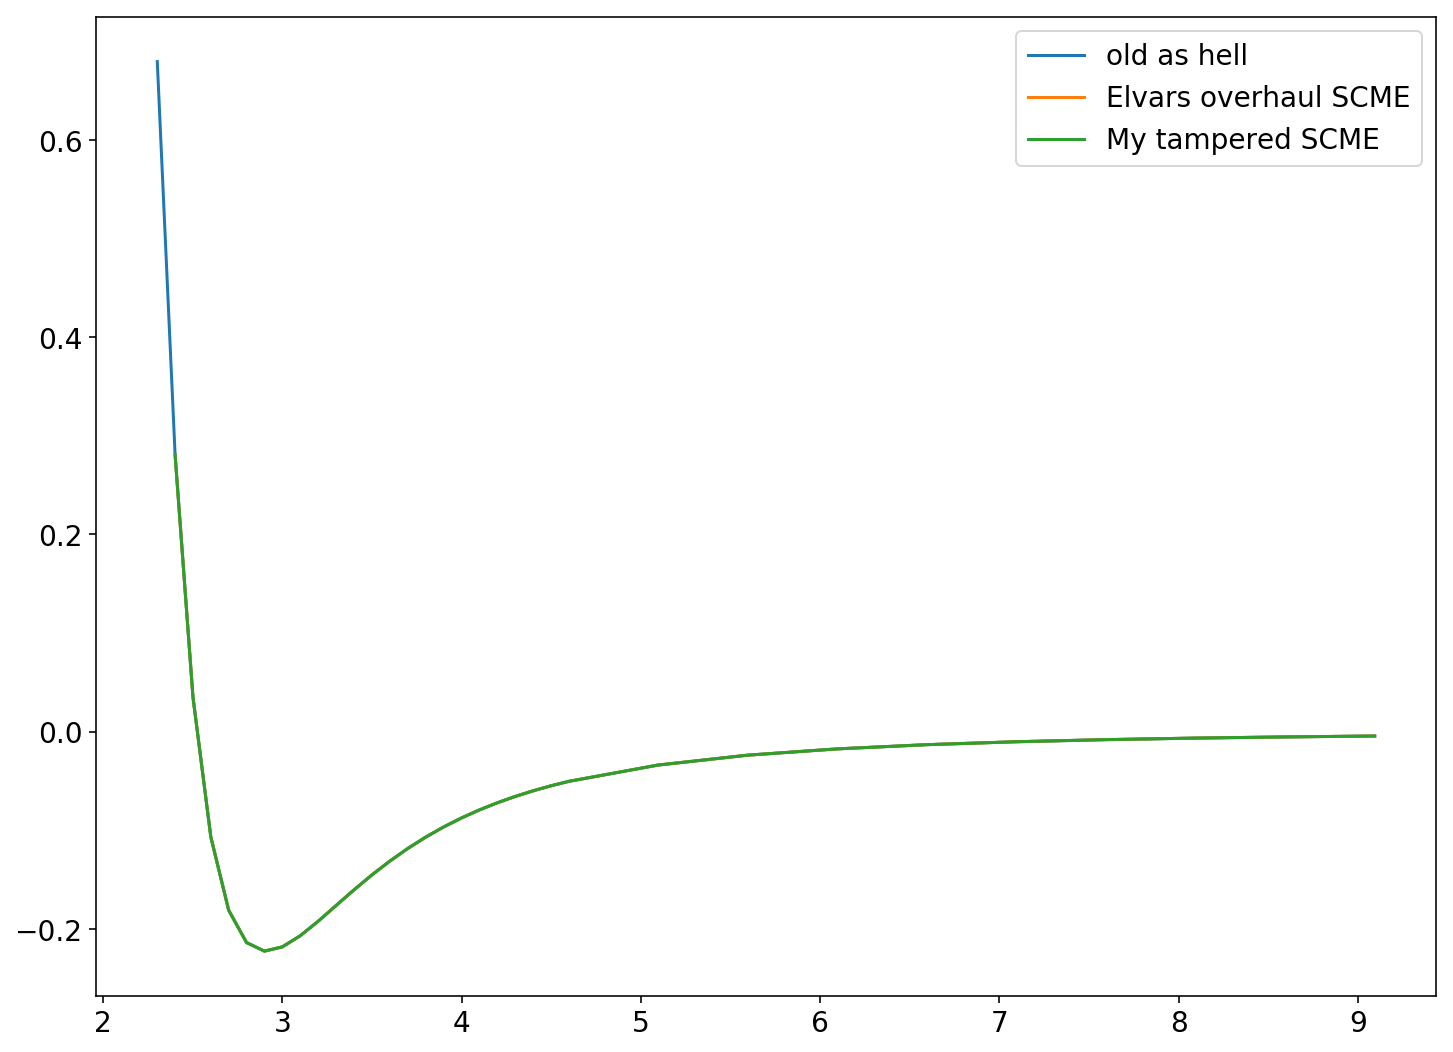

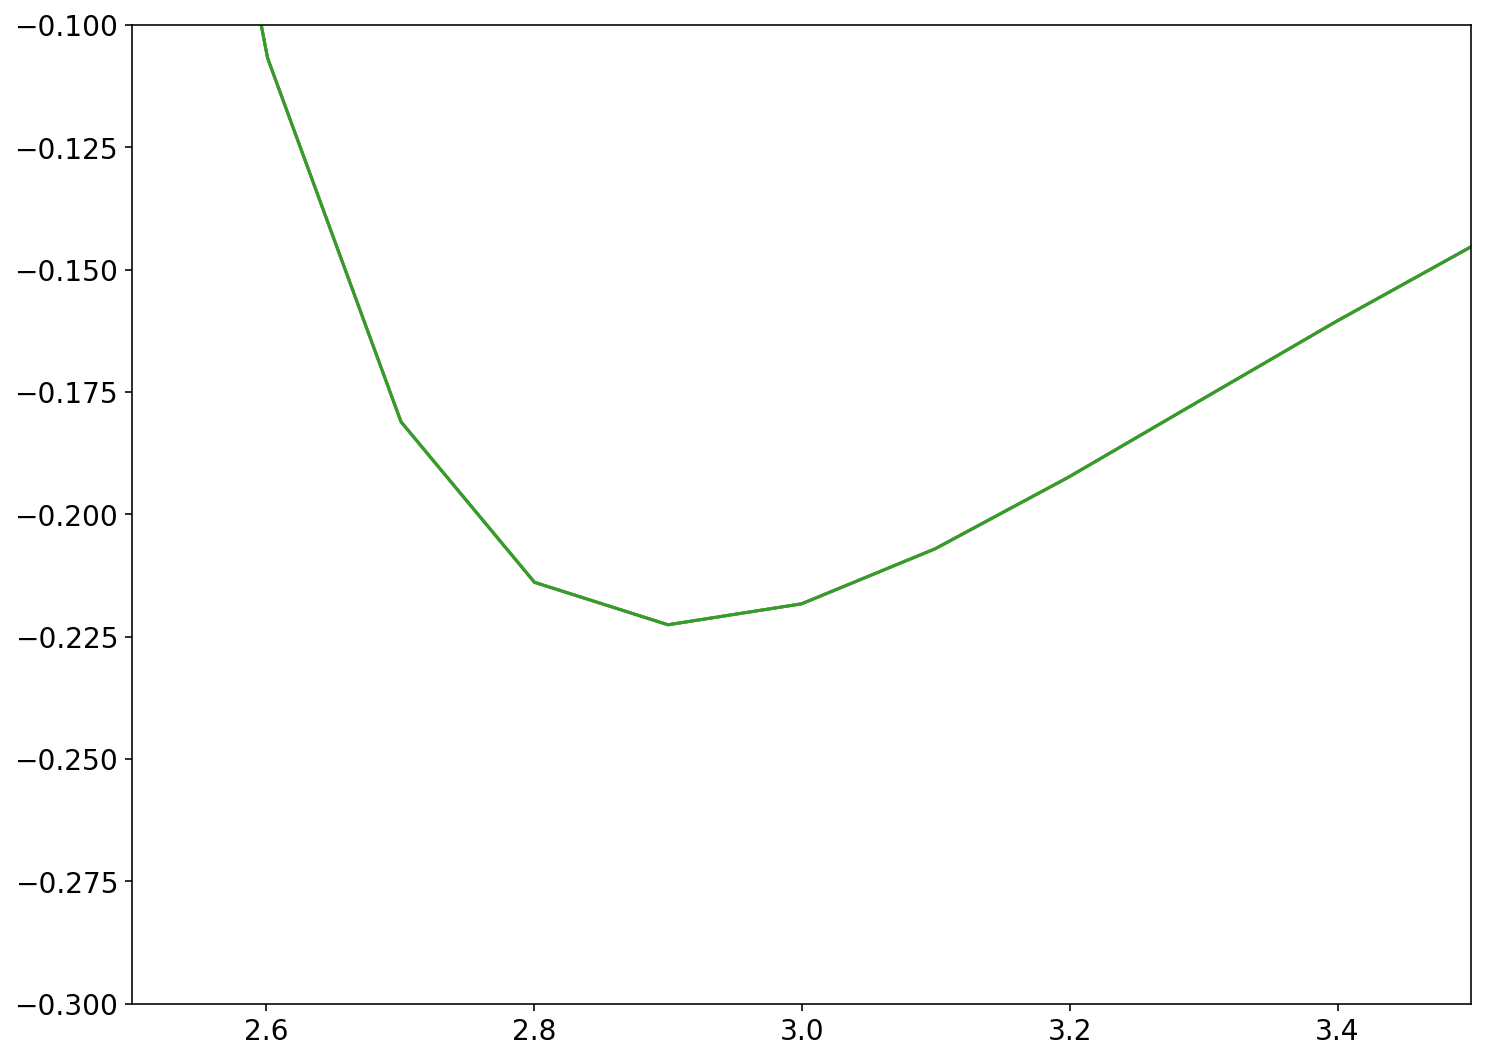

In [6]:
from notebook import *
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
font = { 'size'   : 14}
matplotlib.rc('font', **font);
from typical import *
import glob
import itertools as it

######################################################################## Functions
def get_data(file):
    #print file
    data = np.genfromtxt(file,skip_header=1)
    # Get header
    with open(file,'r') as f:
        line = f.readline()
    params = line.split()
    return data,params

def make_colors(c):
    cmap = plt.get_cmap('viridis')
    colors = [cmap(1.*i/c) for i in range(c)]
    colors.reverse()
    return colors

def compile_data(qmmm_files, mmqm_files, func='PBE'):
    qmmm_files.sort()
    mmqm_files.sort()
    data = {'dist_qmmm': {}, 'dist_mmqm': {}}
    for q, m in it.izip_longest(qmmm_files, mmqm_files):
        if q:
            qmmm, params = get_data(q)
            qg = q.split('_g')[-1].split('.dat')[0]
            data['dist_qmmm'][float(qg)] = qmmm
        if m:
            mmqm, params = get_data(m)
            mg = m.split('_g')[-1].split(func)[0]
            data['dist_mmqm'][float(mg)] = mmqm
        
    return data

        
def pesplot(data, pess, shortlabel=False, dist_mmmm=None, dist_qmqm=None, plotqmqm=True): 
    if not dist_mmmm: 
        dist_mmmm, params = get_data('/Users/asod/Dropbox/HI/SCME/CALCS-OCTOPOLES/SCMESCME.dat')
    if not dist_qmqm: 
        dist_qmqm, params = get_data('/Users/asod/Dropbox/HI/SCME/2017_july/StoneTune_Binding_FullRep/dist_PBE0.16PBE0.16.dat')
    fig, ax = plt.subplots(2, 1, figsize=(10,15));
    ax = ax.ravel()
    for p, pes in enumerate(pess):
        colors = make_colors(len(data[pes]))
        for i, g in enumerate(sorted(data[pes].iterkeys())):
            d = data[pes][g]         #  No more Eoh
            if not shortlabel:
                ax[p].plot(d[:, 0], d[:, 3], color=colors[i], label=pes + ', Stone g: ' + str(g))
            else:
                ax[p].plot(d[:, 0], d[:, 3], color=colors[i], label='g: ' + str(g))

        ax[p].plot(dist_mmmm[:, 0], dist_mmmm[:, 3], 'b--', label='MMMM')
        if plotqmqm:
            ax[p].plot(dist_qmqm[:, 0], dist_qmqm[:, 3], 'r--', label='QMQM')
        ax[p].set_ylabel('Binding Energy (eV)')
        #ax[p].legend(loc='best')
        ax[p].legend(loc='center left', bbox_to_anchor=(1, 0.5))

        ax[p].set_xlim(xlims)
        ax[p].set_ylim(ylims)
        
    ax[p].set_xlabel('Dimer OO distance ($\mathrm{\AA{}}$)')
    return fig, ax

dist_mmmm_old, params = get_data('/Users/asod/Dropbox/HI/SCME/CALCS-OCTOPOLES/SCMESCME.dat')
dist_mmmm_new, params = get_data('/Users/asod/Dropbox/HI/SCME/dist_SCMESCME_OverhaulSCME.dat')
dist_mmmm_my, params = get_data('/Users/asod/Dropbox/HI/SCME/SCME_python/MMMM/dist_SCMESCME.dat')

fig, ax = plt.subplots(1,1, figsize=(12,9))
ax.plot(dist_mmmm_old[:, 0], dist_mmmm_old[:, 3], label='old as hell')
ax.plot(dist_mmmm_new[:, 0], dist_mmmm_new[:, 3], label='Elvars overhaul SCME')
ax.plot(dist_mmmm_my[:, 0], dist_mmmm_my[:, 3], label='My tampered SCME')
ax.legend(loc='best')

fig, ax = plt.subplots(1,1, figsize=(12,9))
ax.plot(dist_mmmm_old[:, 0], dist_mmmm_old[:, 3])
ax.plot(dist_mmmm_new[:, 0], dist_mmmm_new[:, 3])
ax.plot(dist_mmmm_my[:, 0], dist_mmmm_my[:, 3])
ax.legend(loc='best')
ax.set_ylim([-.3, -0.1])
ax.set_xlim([2.5, 3.5])

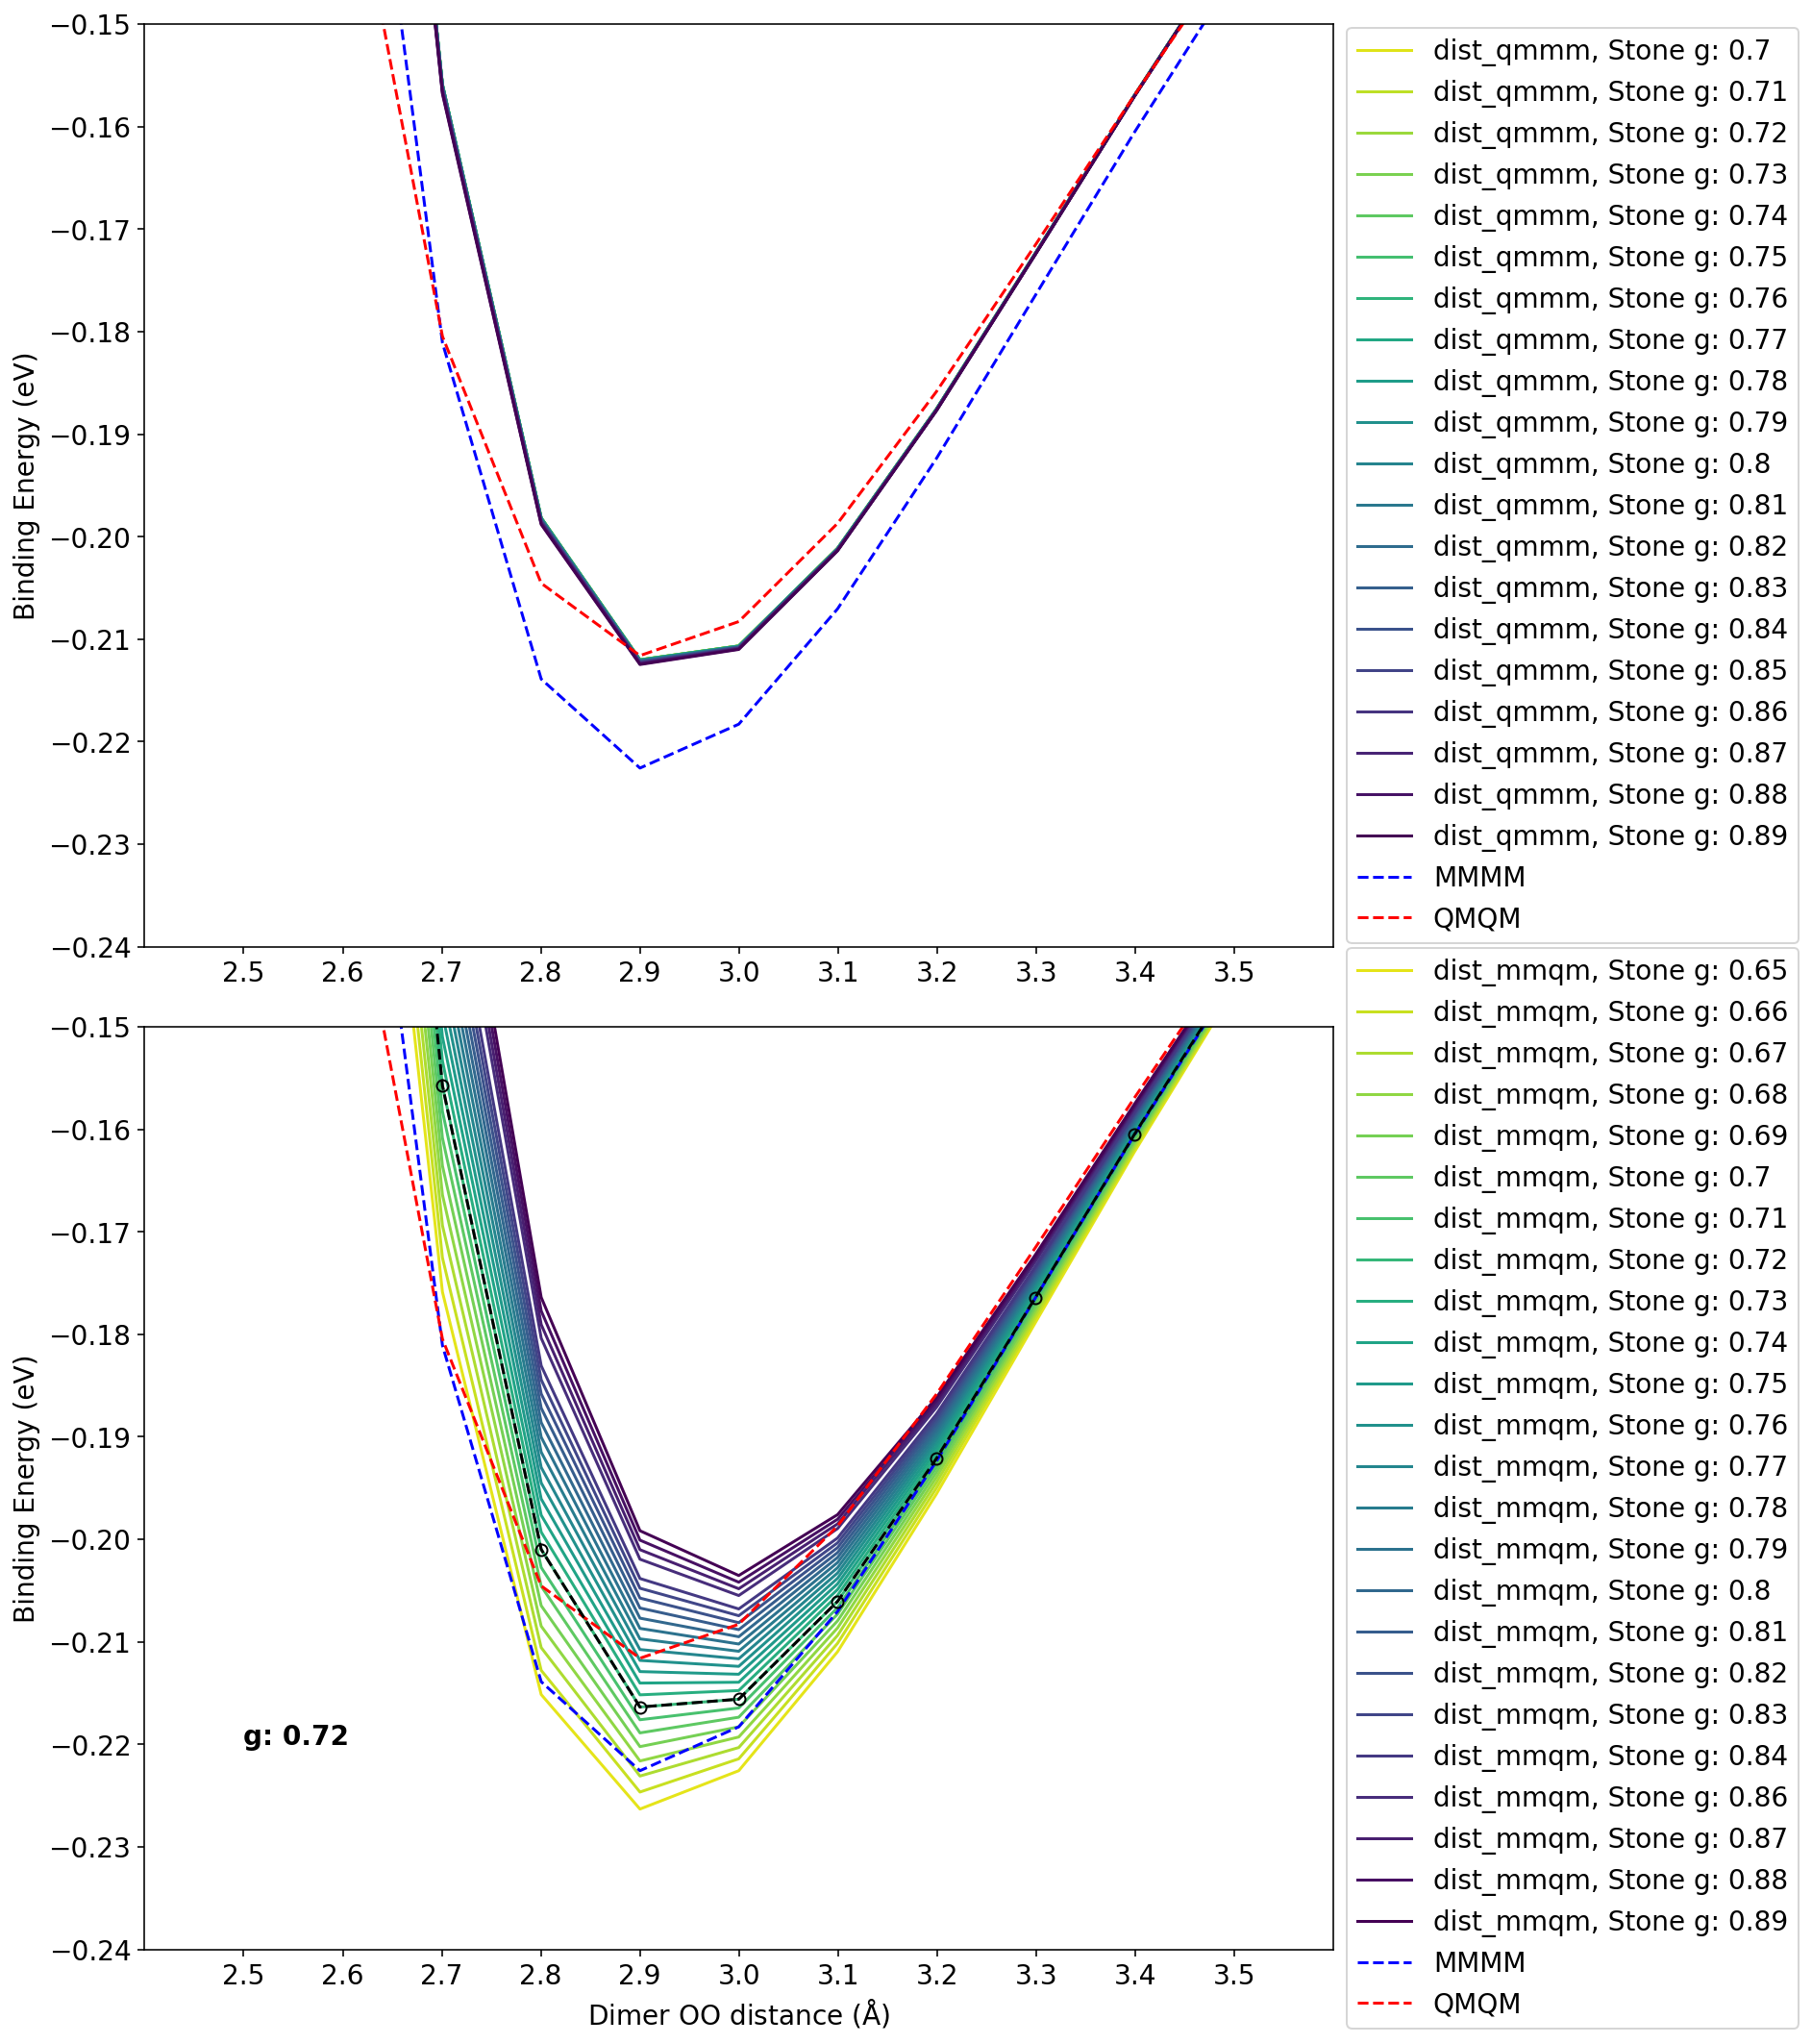

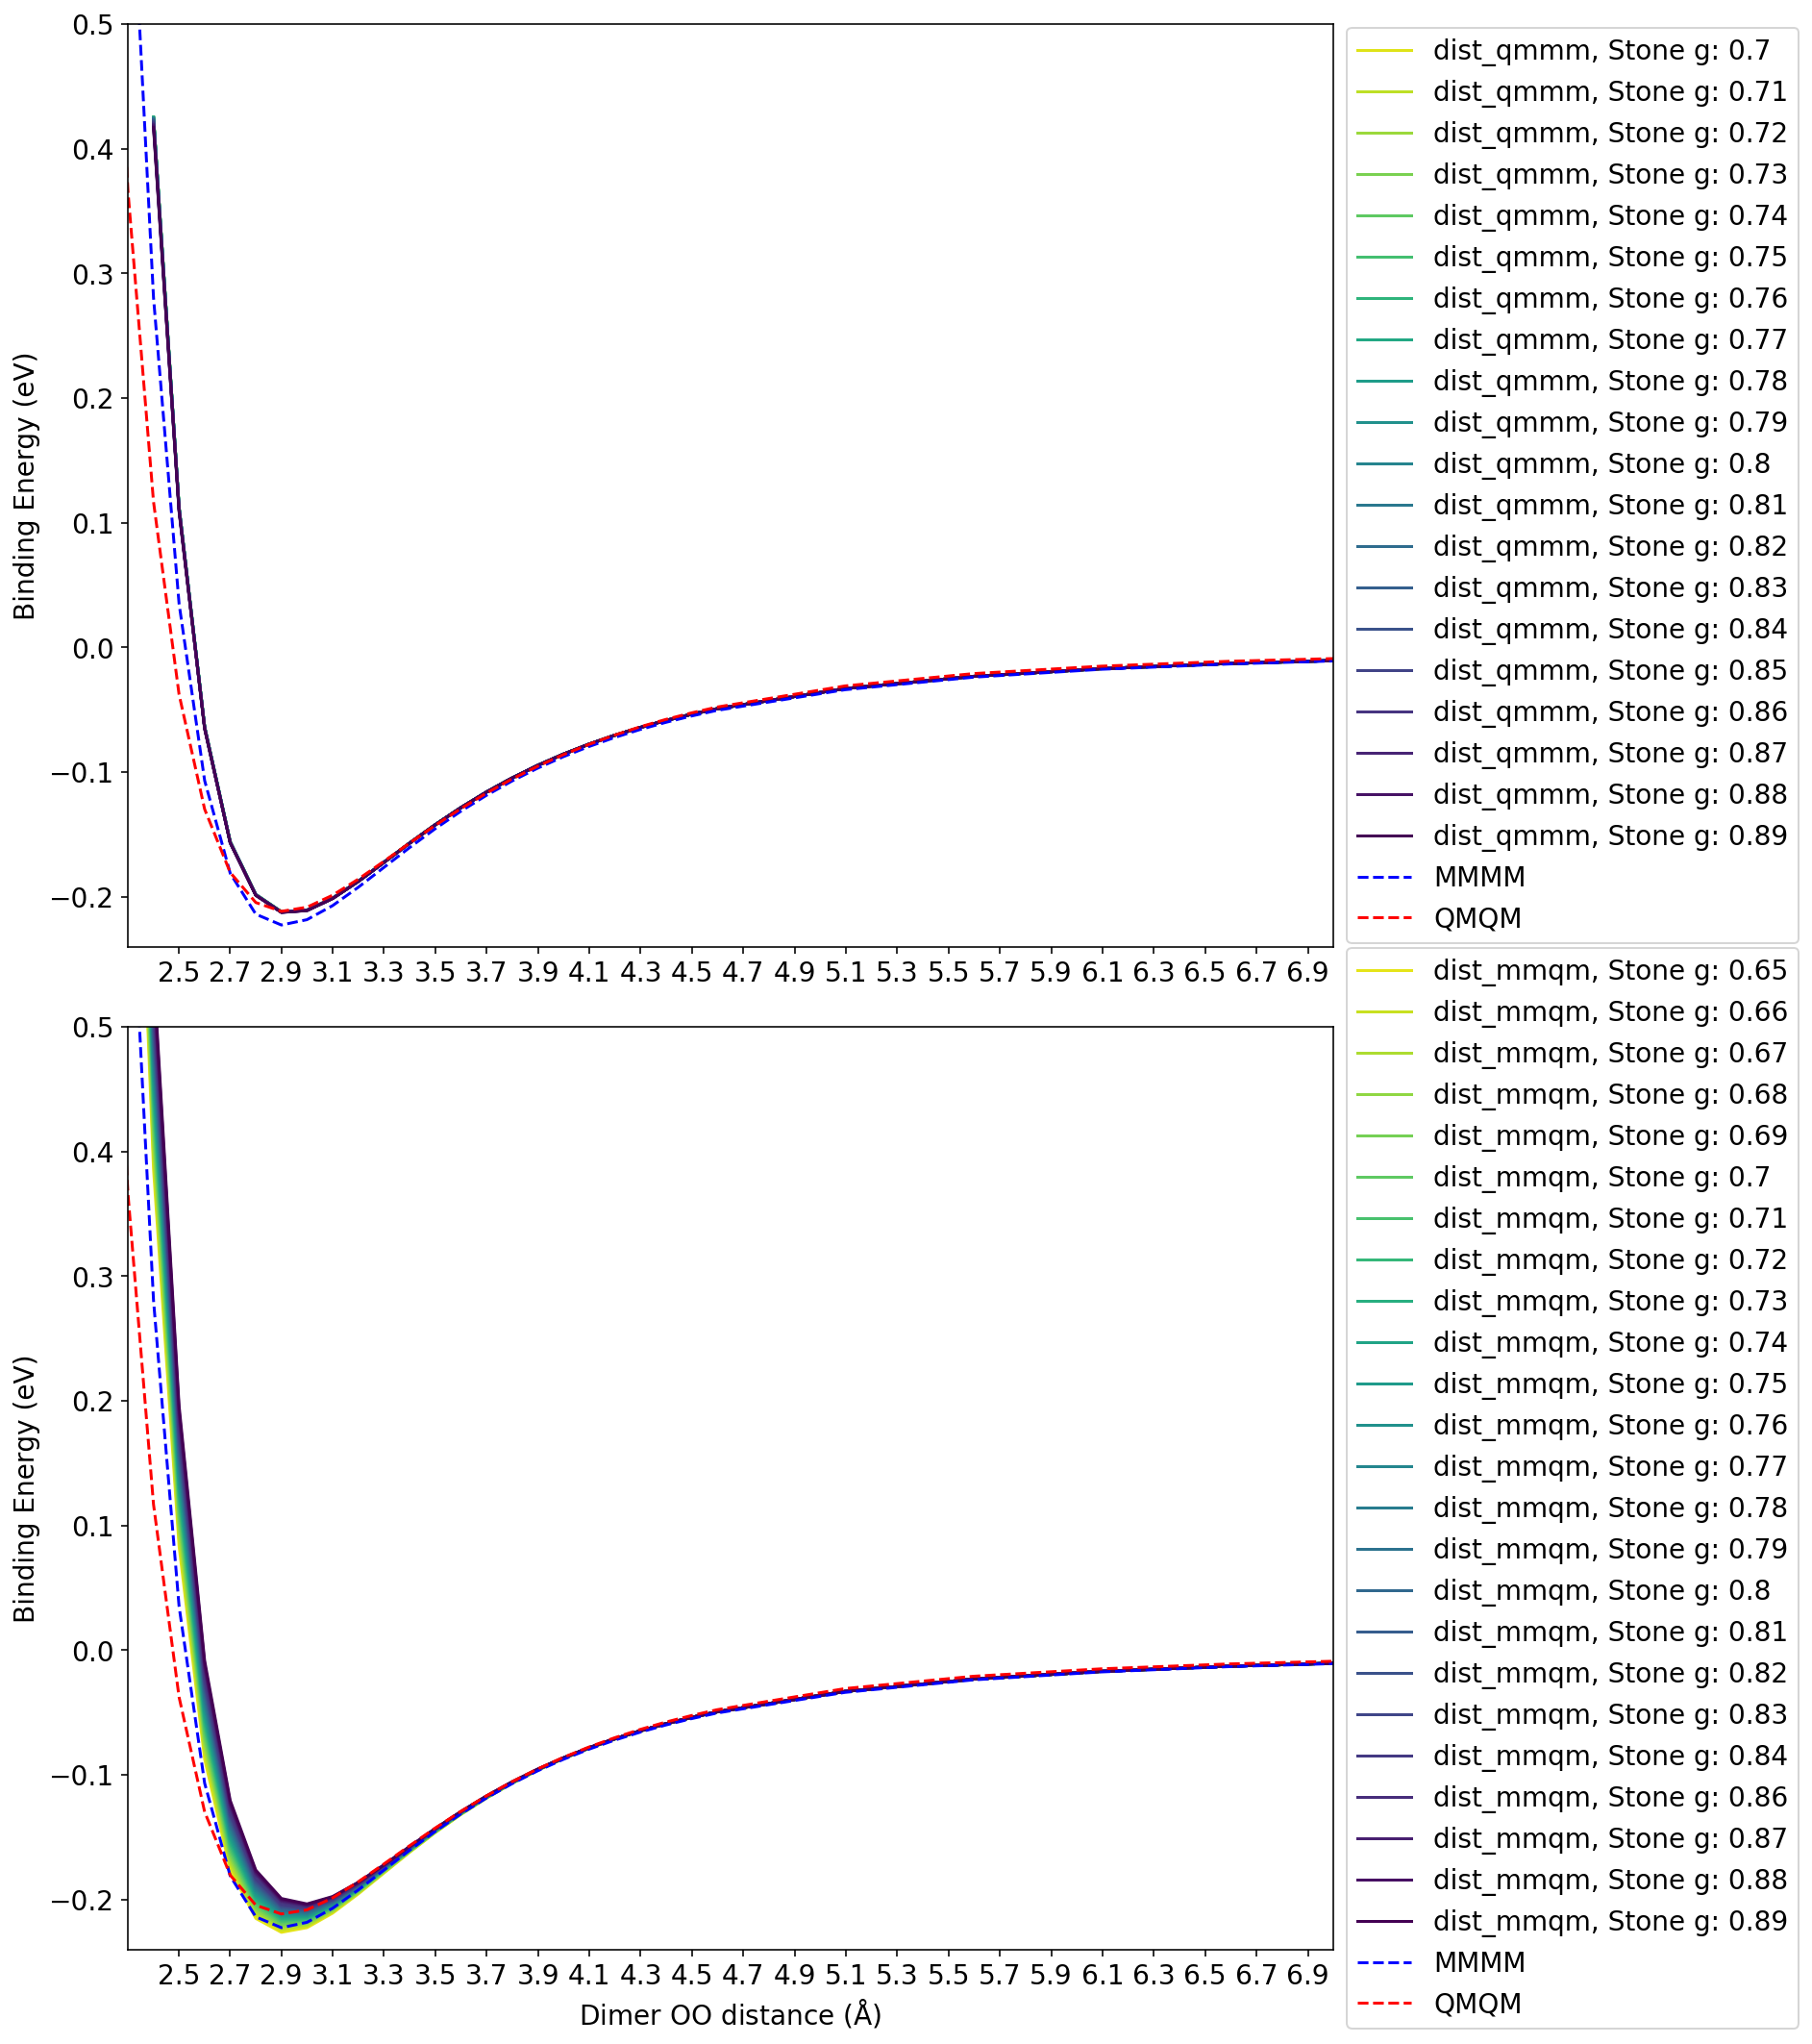

In [39]:


qmmm_files = glob.glob('/Users/asod/Dropbox/HI/SCME/2018_feb/OverhaulSCME_NewGScan/dist_PBE*dat')
mmqm_files = glob.glob('/Users/asod/Dropbox/HI/SCME/2018_feb/OverhaulSCME_NewGScan/dist_SCME*dat')

pes = ('dist_qmmm', 'dist_mmqm')
xlims = [2.4, 3.6]
ylims = [-0.24, -0.15]

data = compile_data(qmmm_files, mmqm_files)
fig, ax = pesplot(data, pes)       
g = 0.72
ax[1].plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3], 'k--o', fillstyle='none')
ax[1].text(2.5, -0.22, 'g: {0:4.2f}'.format(g), fontsize=14, fontweight='bold')

for a in ax:
    a.set_xticks(np.arange(2.5, 3.6, 0.1))
fig.tight_layout()

pes = ('dist_qmmm', 'dist_mmqm')
xlims = [2.3, 7]
ylims = [-0.24, 0.5]

data = compile_data(qmmm_files, mmqm_files)
fig, ax = pesplot(data, pes)        
#ax[0].set_title('Octu/Hexapoles in Vext', size=16)
for a in ax:
    a.set_xticks(np.arange(2.5, 7, 0.2))
fig.tight_layout()



## OverhaulSCME cluster calcs 

-26.0133333333 0.0
-11.34 5.255
-7.852 5.498
7.41166666667 -2.11666666667
7.57857142857 -7.20857142857
-4.9025 0.0
-26.0133333333 0.0
-11.34 5.255
-7.852 5.498
7.41166666667 -2.11666666667
7.57857142857 -7.20857142857
-4.9025 0.0
-26.0133333333 0.0
-11.34 5.255
-7.852 5.498
7.41166666667 -2.11666666667
7.57857142857 -7.20857142857
-4.9025 0.0


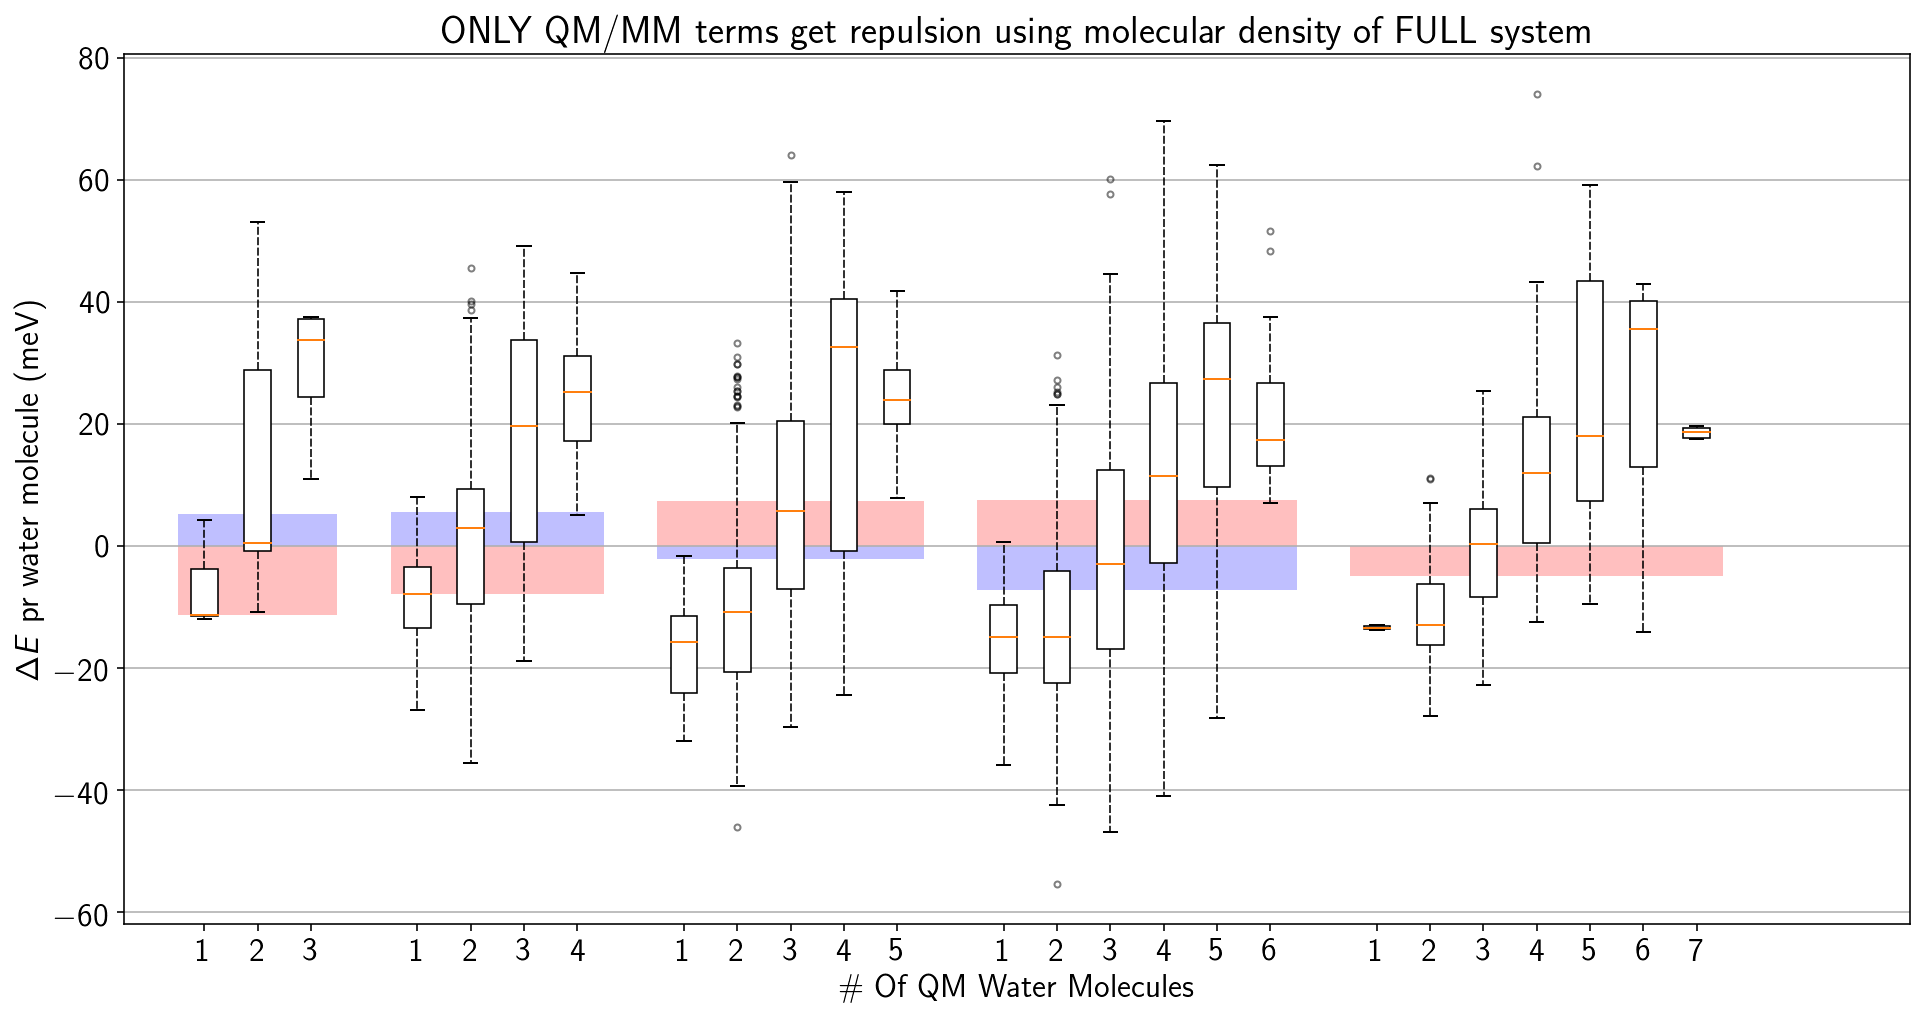

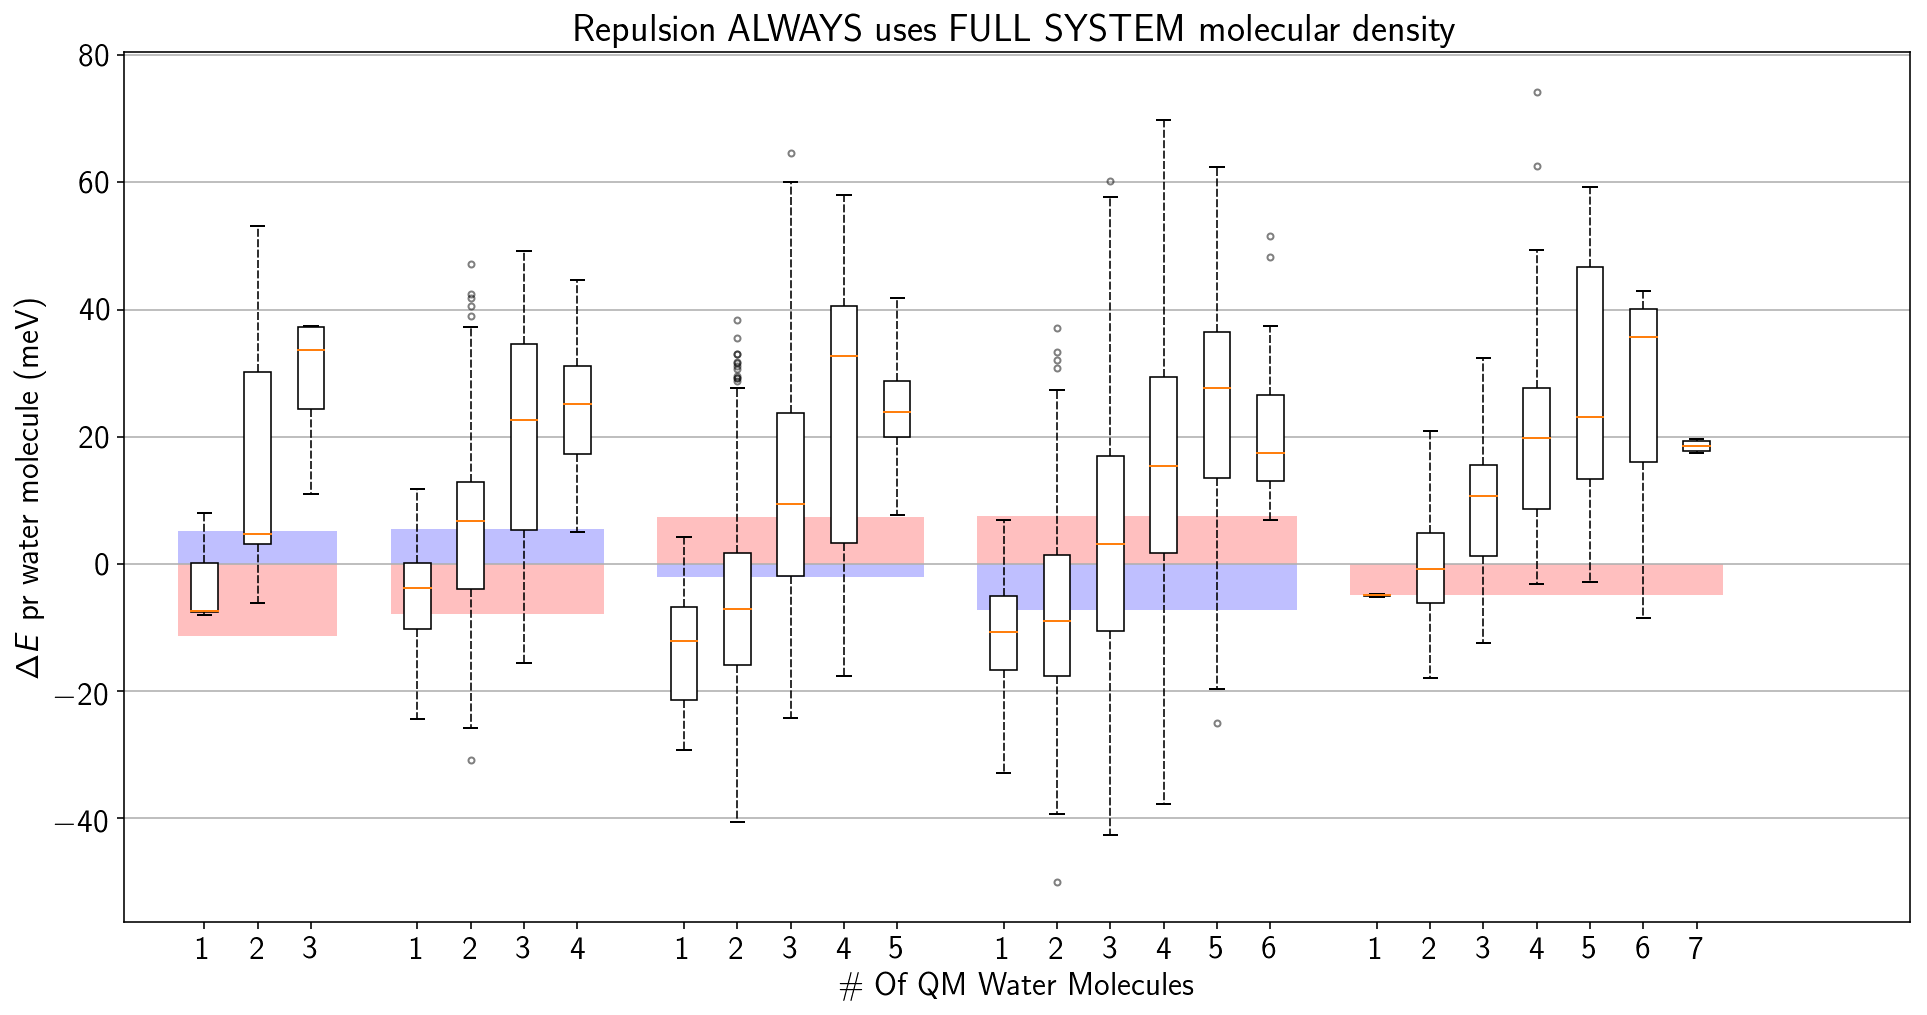

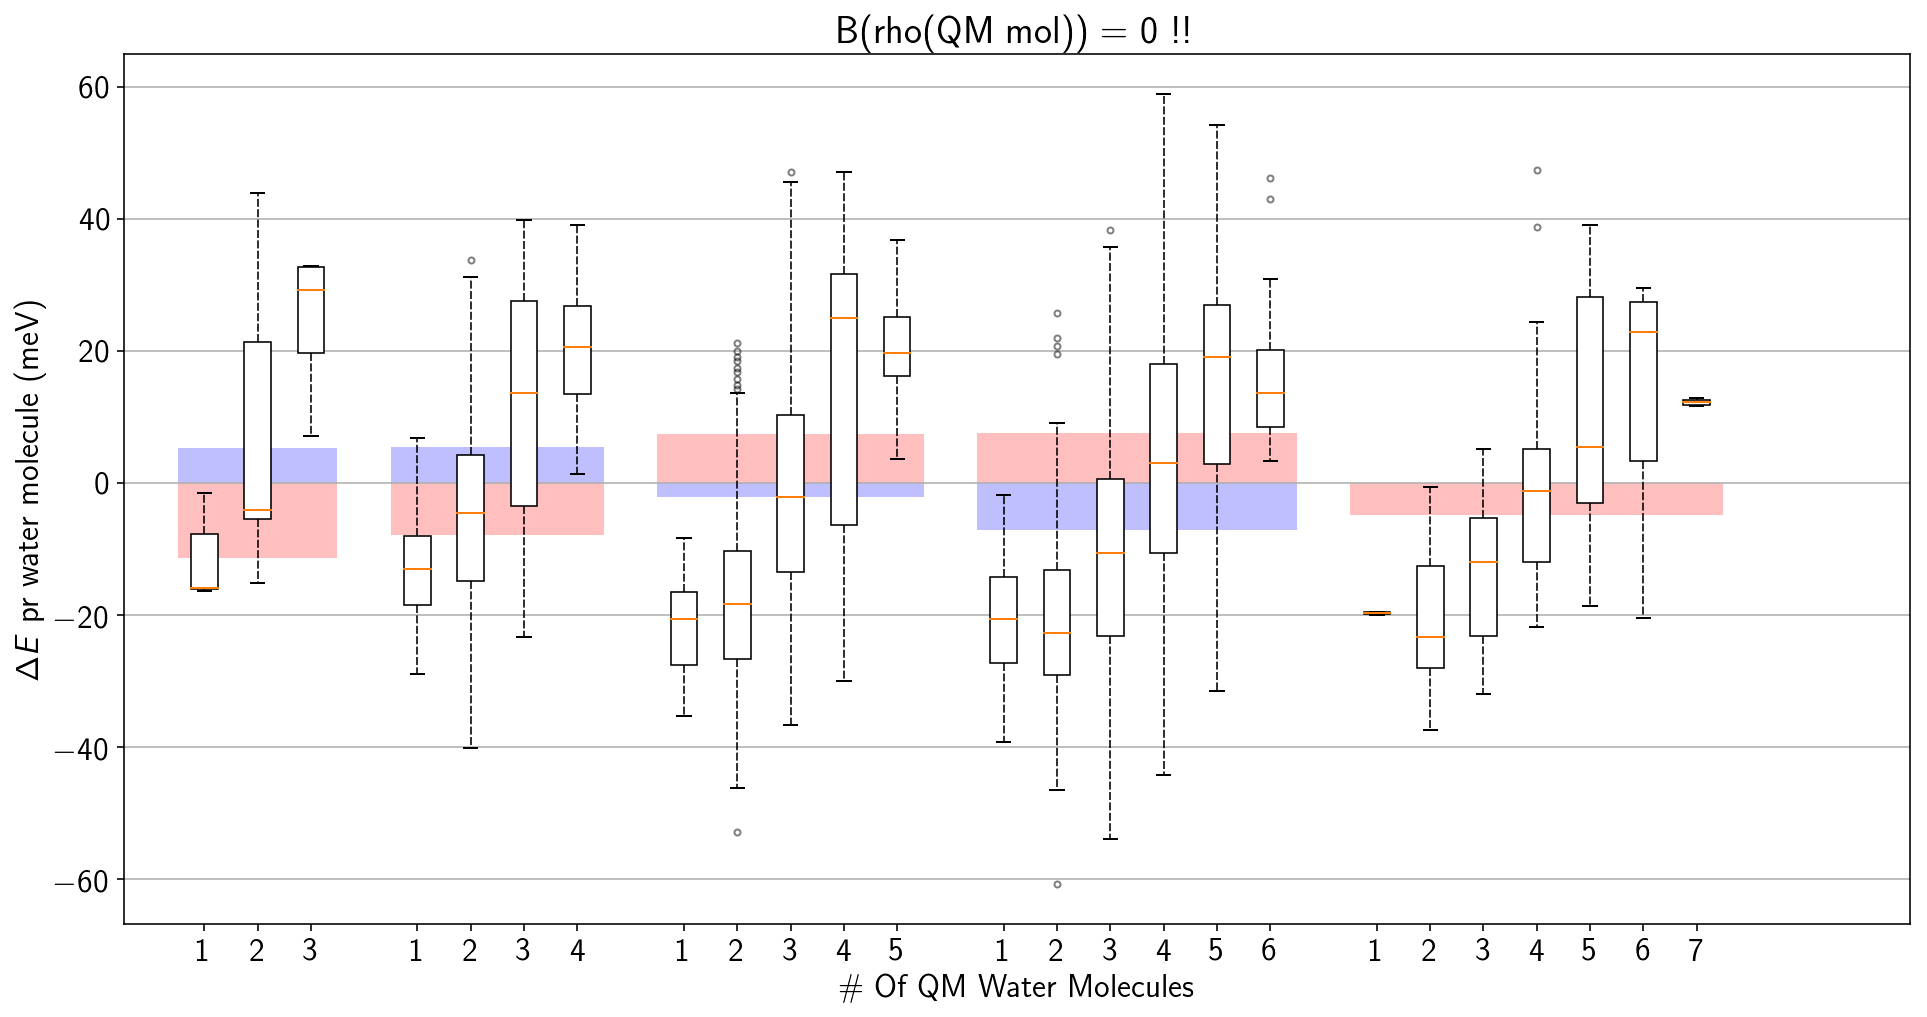

In [1]:
import matplotlib 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Myriad Pro'], 'size':16})
rc('text', usetex=True)
rc('text.latex', preamble='\usepackage{sfmath}')

from waterclusterparser import do_stuff
from typical import *



fil = '/Users/asod/Dropbox/HI/SCME/2018_feb/WaterClusters/*dat'
tit = 'OverhaulSCME'

boxes, rearranged, pos, signedabsmax, maxtheotherway, xlist = do_stuff(fil, 
                                                                       correct_disprep=False, 
                                                                       correct_decouple=False, 
                                                                       printstuff=False,
                                                                       oldschool_repulsion=True)


fig, ax = plt.subplots(figsize=(16,8));            
bp = ax.boxplot(rearranged, positions=pos, meanline=True, patch_artist=True);   
for box in bp['boxes']:
    box.set(edgecolor='k', linewidth=.8, facecolor='w')
for whisker in bp['whiskers']:
    whisker.set(linestyle='--', dashes=(5,1.5), color='k', linewidth=0.8)
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5, markersize=3)

positions = pos
xbars = sum([[x-.5,x+.5] for x in range(1,positions[-1]+2) if x not in positions], [])
xbars = [0.5]+xbars[0:-1]
xbars = np.reshape(xbars, (len(xbars)/2,2))
for i,xb in enumerate(xbars):
    xval = [xb[0],xb[1]]

    ax.fill_between(xval, 0, signedabsmax[i], facecolor='red', alpha=0.25, zorder=1, label='Max. Full QM Difference');
    ax.fill_between(xval, 0, maxtheotherway[i], 
                    facecolor='blue', alpha=0.25, zorder=1, label='Max Difference of Opposite Sign');

ax.set_xticklabels(xlist)

xmin = 2.5
xmax = 36

plt.xlim([xmin, xmax]);

plt.xlabel('\#{} Of QM Water Molecules');
plt.ylabel('$\Delta E$ pr water molecule (meV)');
ax.yaxis.grid(b=True)
handles, labels = ax.get_legend_handles_labels()
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title('ONLY QM/MM terms get repulsion using molecular density of FULL system ');

#ax2 = ax.twiny();
#ax2.set_xlabel(tit, color='k');
#ax2.set_xlim([xmin, xmax]);
#ax2.set_xticks([0.25, 1, 1.9, 2.9, 4.15, 5.6, 7.2, 9]);
#ax2.set_xticklabels(['3','4','5','6','7','8','9','10']);

boxes, rearranged, pos, signedabsmax, maxtheotherway, xlist = do_stuff(fil, 
                                                                       correct_disprep=False, 
                                                                       correct_decouple=False, 
                                                                       printstuff=False,
                                                                       oldschool_repulsion=False)


fig, ax = plt.subplots(figsize=(16,8));            
bp = ax.boxplot(rearranged, positions=pos, meanline=True, patch_artist=True);   
for box in bp['boxes']:
    box.set(edgecolor='k', linewidth=.8, facecolor='w')
for whisker in bp['whiskers']:
    whisker.set(linestyle='--', dashes=(5,1.5), color='k', linewidth=0.8)
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5, markersize=3)

positions = pos
xbars = sum([[x-.5,x+.5] for x in range(1,positions[-1]+2) if x not in positions], [])
xbars = [0.5]+xbars[0:-1]
xbars = np.reshape(xbars, (len(xbars)/2,2))
for i,xb in enumerate(xbars):
    xval = [xb[0],xb[1]]

    ax.fill_between(xval, 0, signedabsmax[i], facecolor='red', alpha=0.25, zorder=1, label='Max. Full QM Difference');
    ax.fill_between(xval, 0, maxtheotherway[i], facecolor='blue', 
                    alpha=0.25, zorder=1, label='Max Difference of Opposite Sign');

ax.set_xticklabels(xlist)

xmin = 2.5
xmax = 36

plt.xlim([xmin, xmax]);

plt.xlabel('\#{} Of QM Water Molecules');
plt.ylabel('$\Delta E$ pr water molecule (meV)');
ax.yaxis.grid(b=True)
handles, labels = ax.get_legend_handles_labels()
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title('Repulsion ALWAYS uses FULL SYSTEM molecular density');


oxes, rearranged, pos, signedabsmax, maxtheotherway, xlist = do_stuff(fil, 
                                                                       correct_disprep=False, 
                                                                       correct_decouple=False, 
                                                                       printstuff=False,
                                                                       oldschool_repulsion=False,
                                                                       yet_another_repulsion=True)


fig, ax = plt.subplots(figsize=(16,8));            
bp = ax.boxplot(rearranged, positions=pos, meanline=True, patch_artist=True);   
for box in bp['boxes']:
    box.set(edgecolor='k', linewidth=.8, facecolor='w')
for whisker in bp['whiskers']:
    whisker.set(linestyle='--', dashes=(5,1.5), color='k', linewidth=0.8)
for flier in bp['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5, markersize=3)

positions = pos
xbars = sum([[x-.5,x+.5] for x in range(1,positions[-1]+2) if x not in positions], [])
xbars = [0.5]+xbars[0:-1]
xbars = np.reshape(xbars, (len(xbars)/2,2))
for i,xb in enumerate(xbars):
    xval = [xb[0],xb[1]]

    ax.fill_between(xval, 0, signedabsmax[i], facecolor='red', alpha=0.25, zorder=1, label='Max. Full QM Difference');
    ax.fill_between(xval, 0, maxtheotherway[i], facecolor='blue', 
                    alpha=0.25, zorder=1, label='Max Difference of Opposite Sign');

ax.set_xticklabels(xlist)

xmin = 2.5
xmax = 36

plt.xlim([xmin, xmax]);

plt.xlabel('\#{} Of QM Water Molecules');
plt.ylabel('$\Delta E$ pr water molecule (meV)');
ax.yaxis.grid(b=True)
handles, labels = ax.get_legend_handles_labels()
ax.get_xaxis().tick_bottom();
ax.get_yaxis().tick_left();
plt.title('B(rho(QM mol)) = 0 !! ');

## This changes very little, lets see what the changes look like on the dimer curve

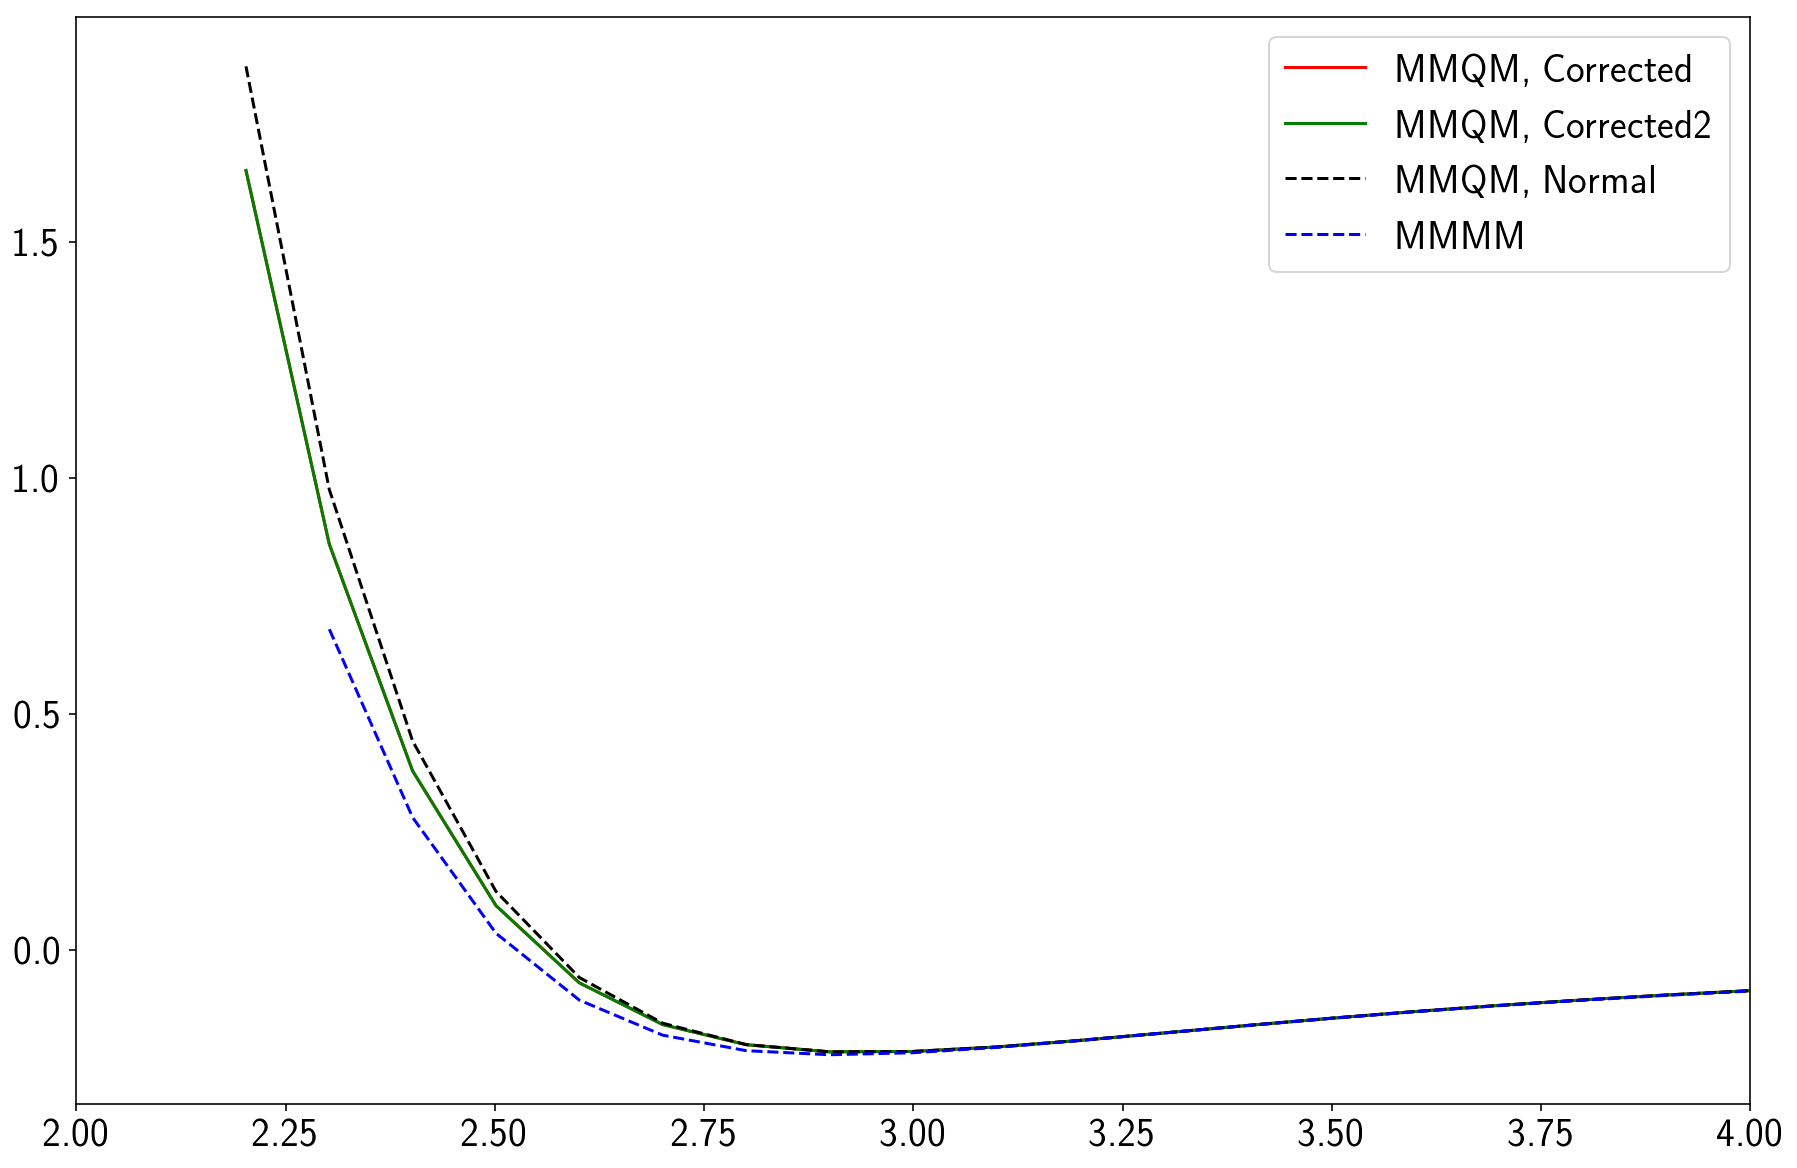

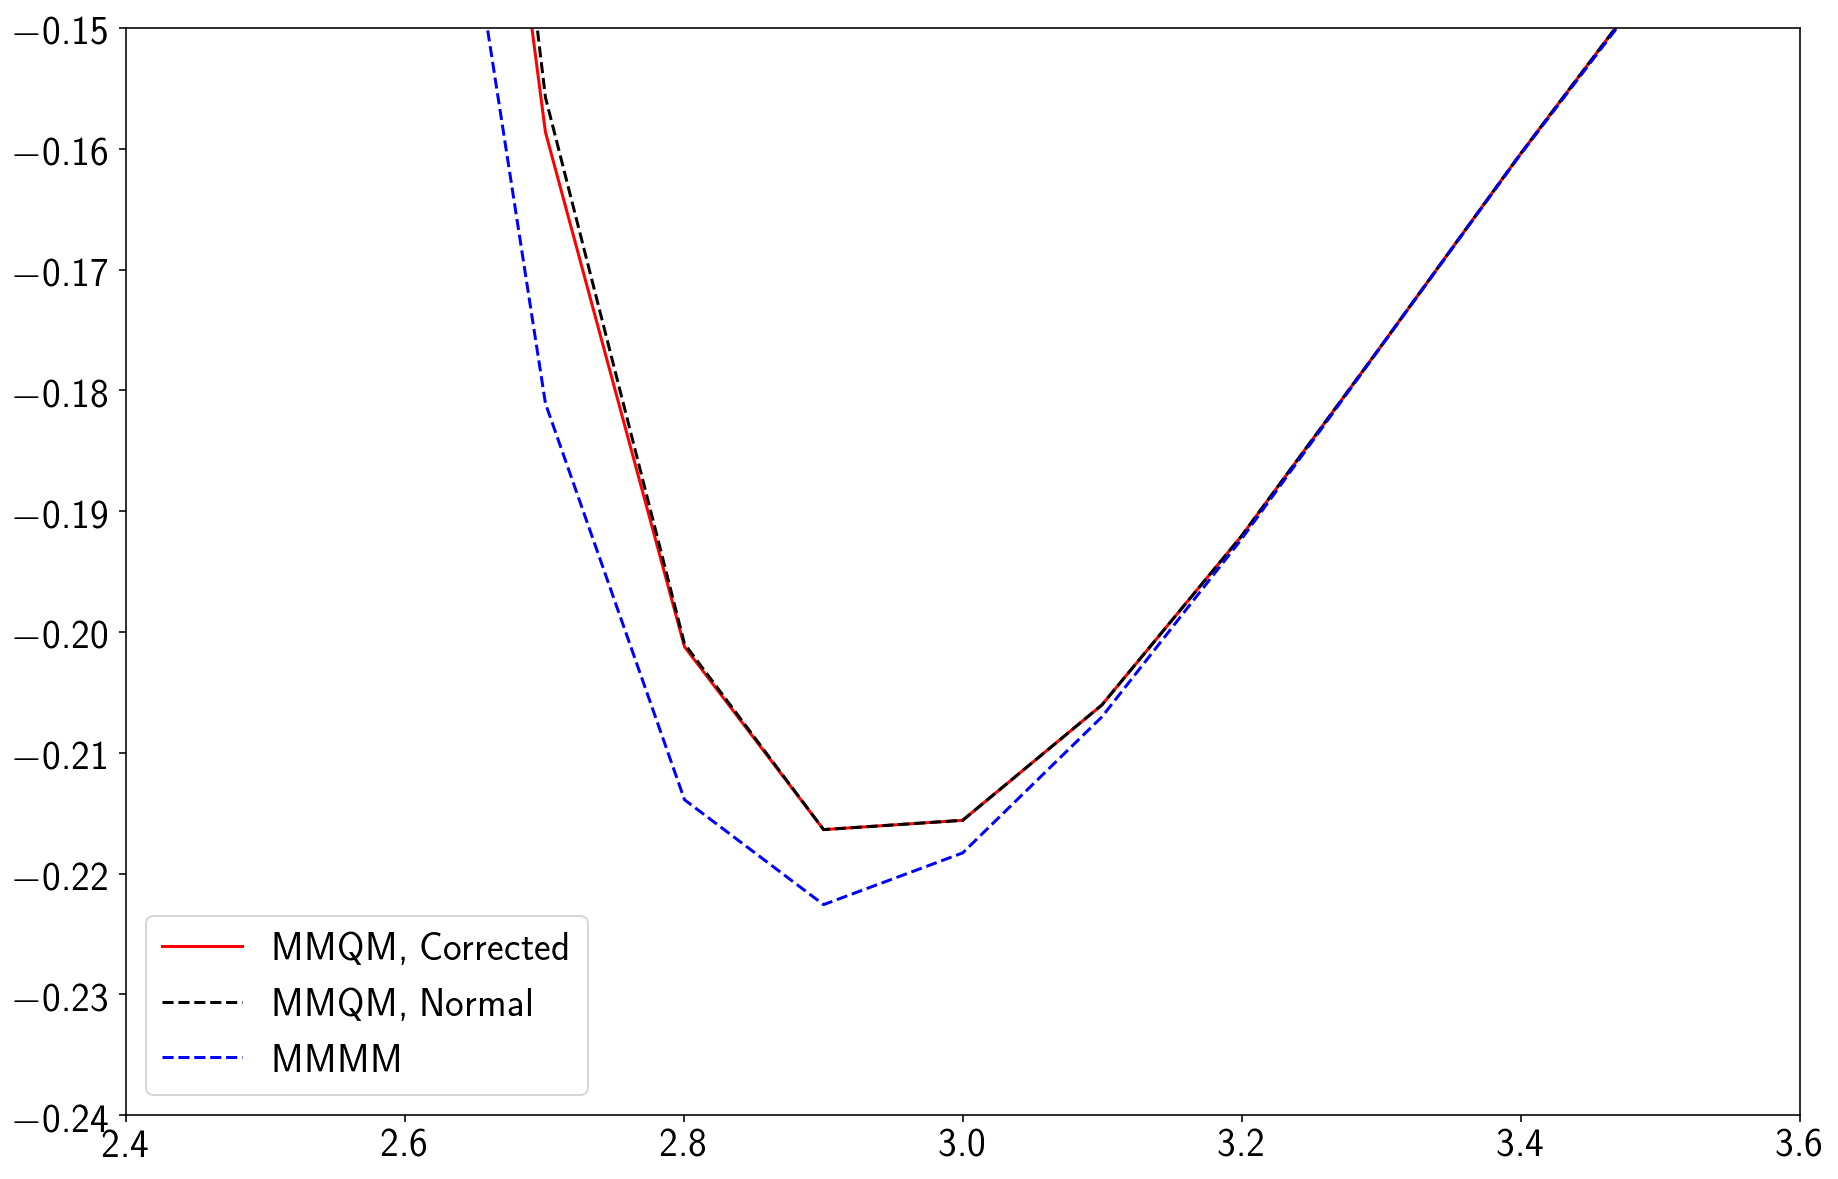

In [9]:
%reset -f
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
font = { 'size'   : 20}
matplotlib.rc('font', **font);
import matplotlib.pyplot as plt


import glob
import numpy as np

import itertools as it
def get_data(file):
    #print file
    data = np.genfromtxt(file,skip_header=1)
    # Get header
    with open(file,'r') as f:
        line = f.readline()
    params = line.split()
    return data,params

def compile_data(qmmm_files, mmqm_files, func='PBE'):
    qmmm_files.sort()
    mmqm_files.sort()
    data = {'dist_qmmm': {}, 'dist_mmqm': {}}
    for q, m in it.izip_longest(qmmm_files, mmqm_files):
        if q:
            qmmm, params = get_data(q)
            qg = q.split('_g')[-1].split('.dat')[0]
            data['dist_qmmm'][float(qg)] = qmmm
        if m:
            mmqm, params = get_data(m)
            mg = m.split('_g')[-1].split(func)[0]
            data['dist_mmqm'][float(mg)] = mmqm
        
    return data

qmmm_files = glob.glob('/Users/asod/Dropbox/HI/SCME/2018_feb/OverhaulSCME_NewGScan/dist_PBE*dat')
mmqm_files = glob.glob('/Users/asod/Dropbox/HI/SCME/2018_feb/OverhaulSCME_NewGScan/dist_SCME*dat')
pes = ('dist_qmmm', 'dist_mmqm')
xlims = [2.4, 3.6]
ylims = [-0.24, -0.15]
data = compile_data(qmmm_files, mmqm_files)

# Adjust Repulsion energy
from ase.calculators.scme.new_scme_interface import SCME_Interface
from ase.calculators.scme.qmmm_repulsion import rep_qmmm_mm
from ase.io import Trajectory
from waterclusterparser import calculate_oldqmmm_disp_rep # is ONLY rep

traj = Trajectory('/Users/asod/Dropbox/HI/SCME/2018_feb/OverhaulSCME_NewGScan/dist_SCME_g0.72PBE0.16.traj')
mm_repulsion_fulldens = np.zeros(len(traj))
mm_repulsion_fulldens2 = np.zeros(len(traj))
mm_repulsion_mmdens = np.zeros(len(traj))

mmidx = [0,1,2,3,4,5]  # this is all bullshit obviously. 

from ase.calculators.scme.qmmm_repulsion import calc_amp, get_moldensities
from scme_qmmm_repulsion_scmestyle import coreint
def repulsion_only_mm_moldens(atoms, mmidx):
    nM = len(atoms)/3  # number of mols

    rho = get_moldensities(atoms[mmidx])
    amp, damp = calc_amp(rho, 1)

    return coreint(atoms, np.repeat(rho, 2), np.repeat(amp, 2), np.repeat(damp, 2))


for i, atoms in enumerate(traj):
    e, _ = rep_qmmm_mm(atoms, [0, 1, 2, 3, 4, 5])
    atoms.center(vacuum=100.)
    atoms.calc = SCME_Interface(atoms)
    atoms.get_potential_energy()
    e2 = atoms.calc.e_mm_rep
    
    mm_repulsion_fulldens[i] = e
    mm_repulsion_fulldens2[i] = e2
    
    e, _ = repulsion_only_mm_moldens(atoms, [0, 1, 2])
    mm_repulsion_mmdens[i] = e
    
    mm = atoms[0, 1, 2]
    mm.center()
        
correction = - mm_repulsion_fulldens + mm_repulsion_mmdens
correction2 = - mm_repulsion_fulldens2 + mm_repulsion_mmdens
    
    
fig, ax = plt.subplots(1,1, figsize=(15,10))
g = 0.72
ax.plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3] + correction, 'r-', fillstyle='none', label='MMQM, Corrected')
ax.plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3] + correction2, 'g-', fillstyle='none', label='MMQM, Corrected2')
ax.plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3], 'k--', fillstyle='none', label='MMQM, Normal')
dist_mmmm, params = get_data('/Users/asod/Dropbox/HI/SCME/CALCS-OCTOPOLES/SCMESCME.dat')
ax.plot(dist_mmmm[:, 0], dist_mmmm[:, 3], 'b--', label='MMMM')
ax.set_xlim([2, 4])
ax.legend(loc='best')

fig, ax = plt.subplots(1,1, figsize=(15,10))
xlims = [2.4, 3.6]
ylims = [-0.24, -0.15]
ax.plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3] + correction, 'r-', fillstyle='none', label='MMQM, Corrected')
ax.plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3], 'k--', fillstyle='none', label='MMQM, Normal')
dist_mmmm, params = get_data('/Users/asod/Dropbox/HI/SCME/CALCS-OCTOPOLES/SCMESCME.dat')
ax.plot(dist_mmmm[:, 0], dist_mmmm[:, 3], 'b--', label='MMMM')
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.legend(loc='best');

In [10]:
print correction - correction2
print 'rep_qmmm_mm of whole system gives (luckily) the same as SCME_Interface'

[ -9.66540515e-06  -6.59197774e-06  -4.52777787e-06  -3.10462103e-06
  -2.12876485e-06  -1.46487456e-06  -1.01392018e-06  -7.05476603e-07
  -4.91903734e-07  -3.43132547e-07  -2.39451355e-07  -1.67161574e-07
  -1.16737495e-07  -8.15512738e-08  -5.69888558e-08  -3.98364716e-08
  -2.78546028e-08  -1.94819391e-08  -1.36295287e-08  -9.53756886e-09
  -6.67571551e-09  -4.67365503e-09  -3.27272795e-09  -2.29220553e-09
  -1.60577186e-09  -2.71655266e-10  -4.61388366e-11  -7.86225954e-12
  -1.34351490e-12  -2.30133700e-13  -3.95023380e-14  -6.79294393e-15
  -1.17002014e-15  -2.01814079e-16]


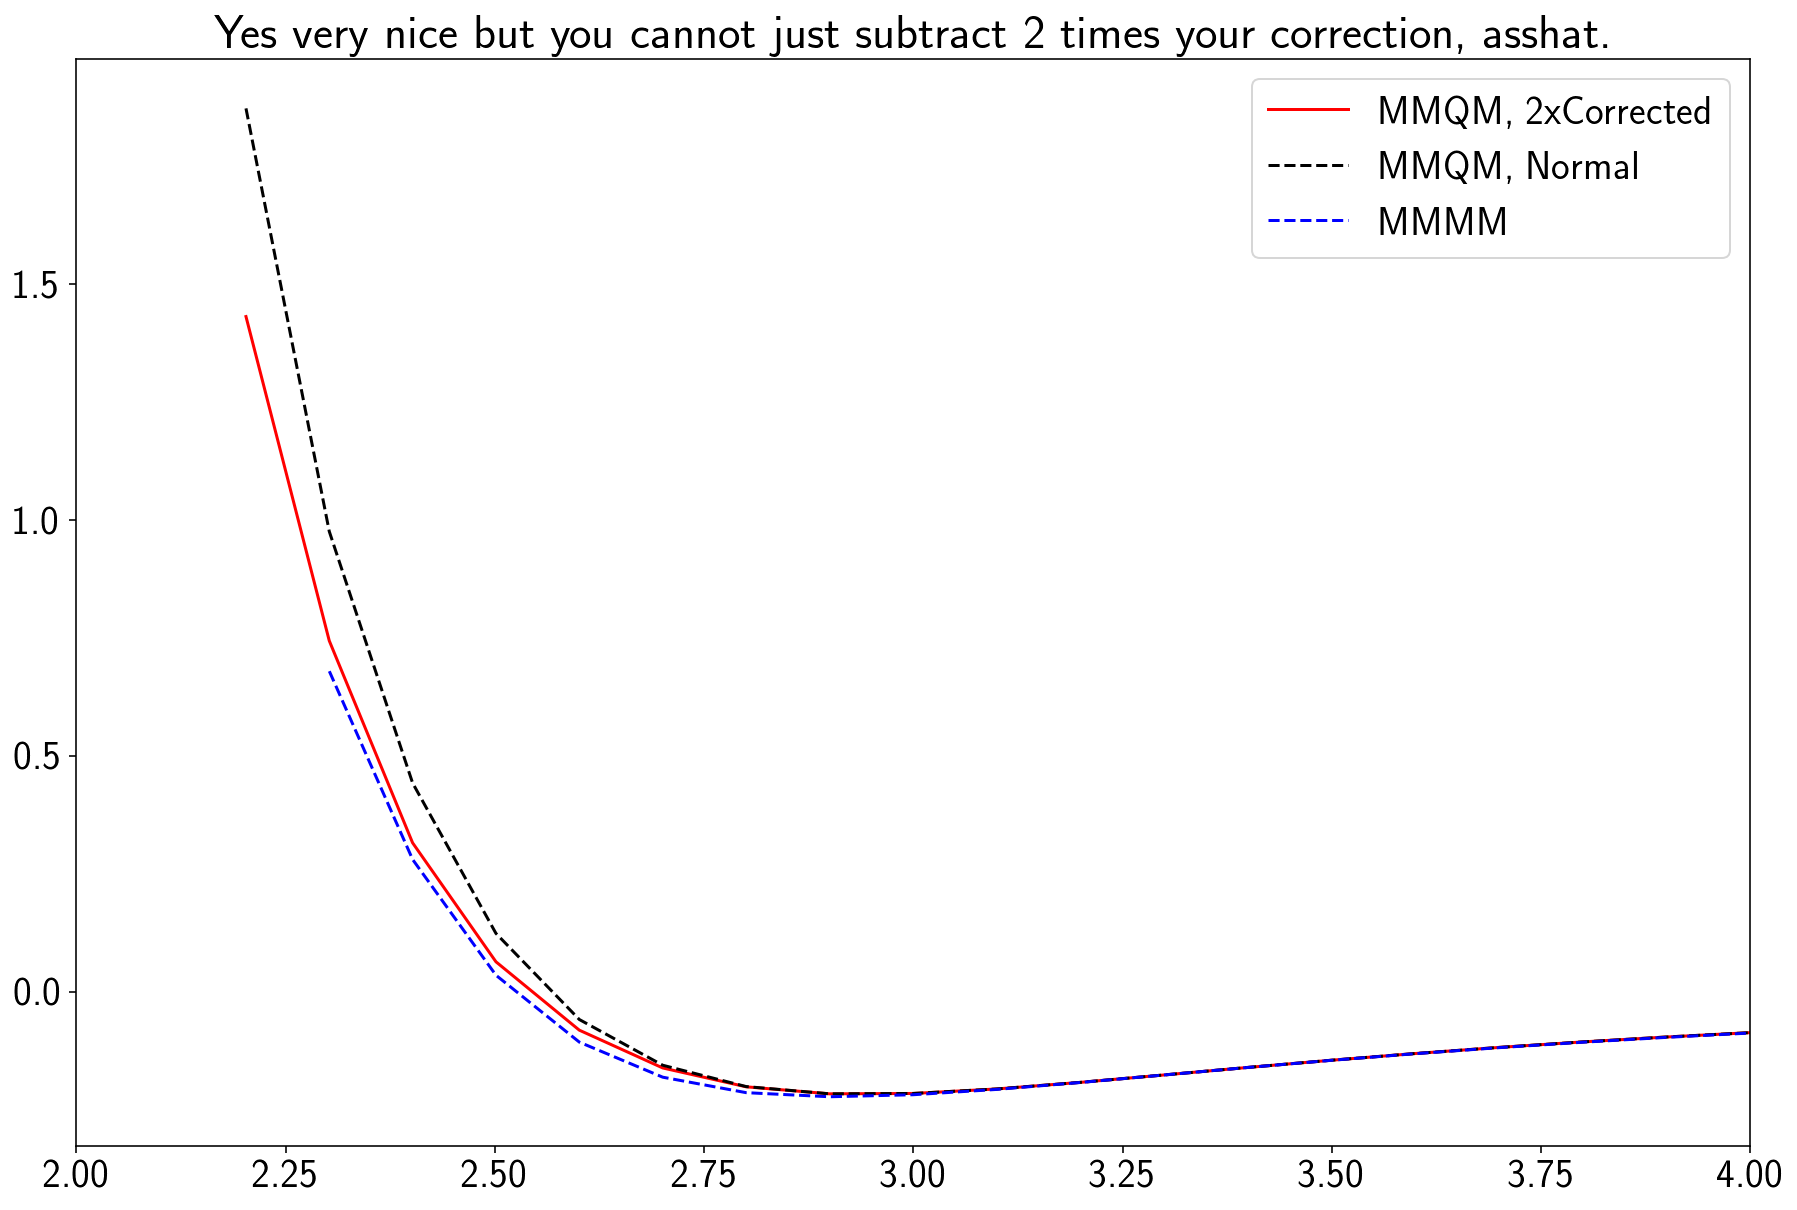

In [33]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
g = 0.72
ax.plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3] + 2 * correction, 
        'r-', fillstyle='none', label='MMQM, 2xCorrected')
ax.plot(data['dist_mmqm'][g][:, 0], data['dist_mmqm'][g][:, 3], 'k--', fillstyle='none', label='MMQM, Normal')
dist_mmmm, params = get_data('/Users/asod/Dropbox/HI/SCME/CALCS-OCTOPOLES/SCMESCME.dat')
ax.plot(dist_mmmm[:, 0], dist_mmmm[:, 3], 'b--', label='MMMM')
ax.set_xlim([2, 4])
#ax.text(6.0, 1.5, 'g: {0:4.2f}'.format(g), fontsize=16, fontweight='bold')
ax.legend(loc='best');
plt.title('Yes very nice but you cannot just subtract 2 times your correction, asshat.');

## What I did for the dimer, and why its the same as I already did for the clusters

Since the QM/MM dimer only has 1 MM molecule, I cannot use SCME_Interface() to calculate the repulsion, it **needs** at least two molecules to do anything. And that would give the wrong density. Thus, I made the densities and amplitudes of a single SCME molecule (zero, apparently) and put that into a new coreint calculation. 


The above cluster calculation correction calculates the mm repulsion on densities **only** from the **mm subsystem ** but the QM/MM term **still** has the full density. This is **different** from the dimer case, where I effectively used the density for the mm subsystem only, for the QM/MM repulsion term (the only repulsion term there is, in this case)


To replicate this (and apparently get better walls) I need to **also** calculate the densities this way for the clusters. How does that work?


The repulsion energy is given by:
\begin{equation}
E_{\rm rep} = \sum_{i < j} \left( 1 + B(\rho_i(r_{ij})) + B(\rho_j(r_{ij})) 
                           \right) r_{ij}^{-b} e^{-c r_{ij}}
\end{equation}

And the molecular densities **at molecule i ** $\rho_i(r_{ij})$ are exponential weight functions:

\begin{equation}
\rho_{i}(r_{ij}) = C \sum_{j \neq i} \frac{e^{-d r_{ij}}}{r^3_{ij}}
\end{equation}

So for molecule $m$, *all* other molecules are used in the density.

The densities are used for the piecewise amplitude function $B(\rho)$:

\begin{equation} 
B(\rho(r_{ij})) = 
   \begin{cases} 
        0 & \mathrm{for} &  \rho(r_{ij}) \leq 1600
        \\
        \sum_{n=0}^5 a_n \rho^n(r_{ij}) & \mathrm{for} &   8000 > \rho(r_{ij}) > 1600 
        \\
        0.0875 &  \mathrm{for} & 8000 \leq \rho(r_{ij}) 
   \end{cases}
\end{equation}



But **should** the density for a QM/MM system really be evaluated from all other molecules? 

What should it be for the 